In [ ]:
##20 cm spacing(0,0)

Total number of events: 5000


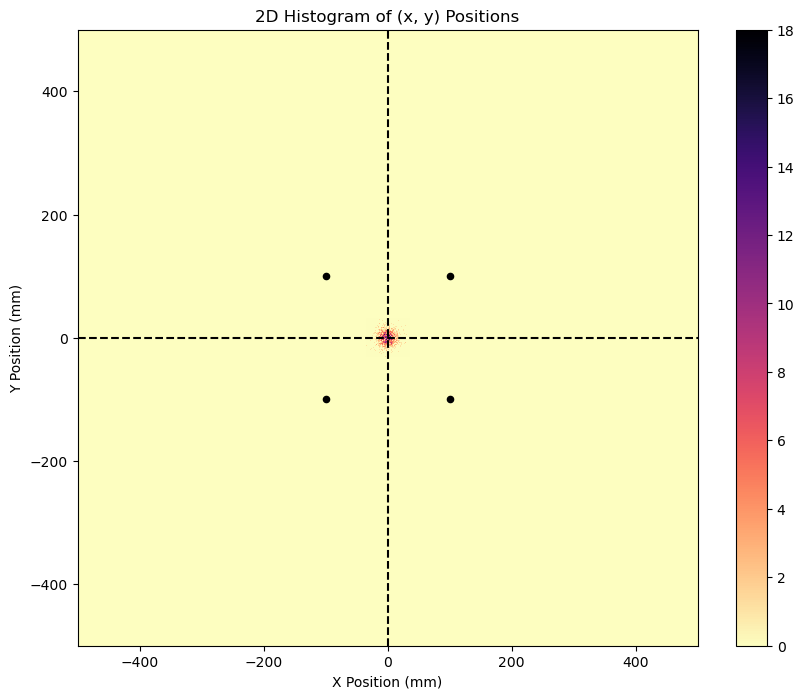

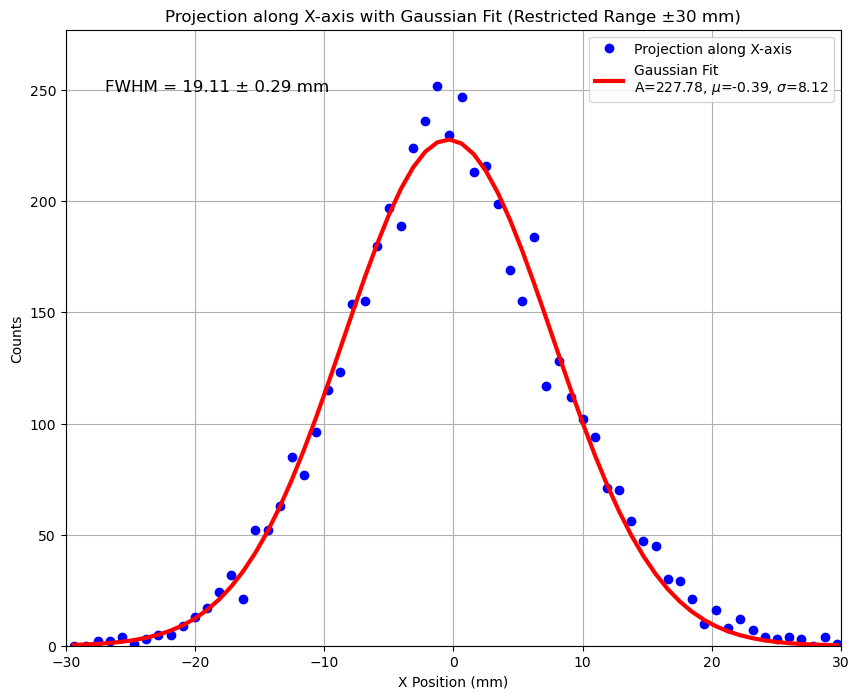

Chi-squared: 137.57
Degrees of freedom: 61
Critical value (df=61, alpha=0.05): 80.23
The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).


In [76]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

def calculate_cells_fired(M, Nph):
    total_cells_fired = []
    for nph in Nph:
        total_cells_fired.append(round(M * (1 - math.exp(-nph / M))))
    return total_cells_fired

def calculate_total_charge_output(total_cells_fired, G, q):
    total_charge_output = [cells_fired * G * q for cells_fired in total_cells_fired]
    return total_charge_output

def read_Nph_from_file(filename):
    Nph_by_event = {}
    current_event = None
    event_counter = 0  # Counter to differentiate events with the same ID
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("Event ID"):
                event_id = float(line.split(":")[1].strip())
                if event_id in Nph_by_event:
                    event_id = f"{event_id}_{event_counter}"  # Append counter to make event IDs unique
                    event_counter += 1
                else:
                    event_counter = 0  # Reset counter when encountering a new event ID
                current_event = event_id
                Nph_by_event[current_event] = {0: 0, 1: 0, 2: 0, 3: 0}
            elif line.startswith("Detector ID"):
                parts = line.split(":")
                detector_id = int(float(parts[0].split()[-1]))
                Nph = float(parts[1].strip())
                if current_event in Nph_by_event:  
                    Nph_by_event[current_event][detector_id] = Nph
    return Nph_by_event

def calculate_position(Q_values, detector_positions):
    numerator_x = sum(Q_i**2 * pos[0] for Q_i, pos in zip(Q_values, detector_positions))
    numerator_y = sum(Q_i**2 * pos[1] for Q_i, pos in zip(Q_values, detector_positions))
    denominator = sum(Q_i**2 for Q_i in Q_values)

    x_position = numerator_x / denominator
    y_position = numerator_y / denominator

    return x_position, y_position

# Constants (MPPC S14160-6050HS)
M = 14331
G = 2.5e6  # G value
q = 1.6e-19  # charge of the electron value

# Detector positions
detector_positions = {
    0: (-10, 10),
    1: (-10, -10),
    2: (10, 10),
    3: (10, -10)
}

# Example usage:
filename = "/Users/rishaplamichhane/Downloads/MAPP_2_new copy/build_2/2.5 cm thickness/20 cm spacing/center/1000_events_detector_id_counts_all_events.txt"  # Update with the filename generated from the previous code
Nph_by_event = read_Nph_from_file(filename)

# Calculate the total number of events
total_events = len(Nph_by_event)
print("Total number of events:", total_events)

x_values = []
y_values = []

for event_id, Nph_by_detector in Nph_by_event.items():
    total_fired = calculate_cells_fired(M, list(Nph_by_detector.values()))
    total_charge = calculate_total_charge_output(total_fired, G, q)
    detector_positions_sorted = [detector_positions[id] for id in sorted(Nph_by_detector.keys())]
    resulting_position = calculate_position(total_charge, detector_positions_sorted)
    x_values.append(resulting_position[0])
    y_values.append(resulting_position[1])
    
# Convert to NumPy arrays and multiply by 10 to convert from cm to mm
x_values_mm = np.array(x_values) * 10
y_values_mm = np.array(y_values) * 10

# Create a 2D histogram
plt.figure(figsize=(10, 8))
hist, x_edges, y_edges, _ = plt.hist2d(x_values_mm, y_values_mm, bins=75, cmap='magma_r')
cbar = plt.colorbar()
cbar.set_label('')  # Remove the label from the colorbar
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('2D Histogram of (x, y) Positions')
plt.grid(False)

plt.scatter([-100, -100, 100, 100], [100, -100, 100, -100], color='black', s=20)
    
# Add dashed lines for x and y axes
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.gca().set_facecolor('#FDFEC0')
plt.show()

# Create a 1D histogram projection along the X-axis
projection_x = np.sum(hist, axis=1)

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit Gaussian curve to the projection data with restricted range and bounds
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
restricted_range = (np.abs(x_bin_centers) <= 30)  # Restricting to ±30 mm
x_bin_centers_restricted = x_bin_centers[restricted_range]
projection_x_restricted = projection_x[restricted_range]
p0 = [max(projection_x_restricted), np.mean(x_bin_centers_restricted), (max(x_bin_centers_restricted) - min(x_bin_centers_restricted)) / 4]  # Updated initial guess
bounds = ([0, -30, 0], [np.inf, 30, np.inf])  # Bounds for parameters (lower, upper)
popt, pcov = curve_fit(gaussian, x_bin_centers_restricted, projection_x_restricted, p0=p0, bounds=bounds)

# Plot the projection along X-axis with restricted range
plt.figure(figsize=(10, 8))
plt.plot(x_bin_centers, projection_x, 'bo', label='Projection along X-axis')
plt.xlabel('X Position (mm)')
plt.ylabel('Counts')
plt.title('Projection along X-axis with Gaussian Fit (Restricted Range ±30 mm)')
plt.grid(True)

# Plot Gaussian fit
plt.plot(x_bin_centers_restricted, gaussian(x_bin_centers_restricted, *popt), 'r-', linewidth=3, label=f'Gaussian Fit\nA={popt[0]:.2f}, $\mu$={popt[1]:.2f}, $\sigma$={popt[2]:.2f}')  # Set linewidth=2 (or any other suitable value)

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # FWHM = 2 * sqrt(2 * ln(2)) * sigma

# Estimate uncertainty in FWHM
sigma_uncertainty = np.sqrt(np.diag(pcov))[2]  # Standard deviation of sigma parameter
fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty  # Uncertainty in FWHM

# Add legend and annotate FWHM
plt.legend()
plt.annotate(f'FWHM = {fwhm:.2f} ± {fwhm_uncertainty:.2f} mm', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

plt.xlim(-30, 30)  # Adjust x-axis limits to show restricted range
plt.ylim(0, max(projection_x) * 1.1)  # Adjust y-axis limits for better visualization
plt.show()

# Perform chi-squared test
# Compute the expected values from the Gaussian fit
expected_counts = gaussian(x_bin_centers_restricted, *popt)

# Calculate the degrees of freedom
# Number of bins - number of parameters fitted (A, mu, sigma)
degrees_of_freedom = len(projection_x_restricted) - 3

# Calculate the chi-squared statistic
chi_squared = np.sum((projection_x_restricted - expected_counts)**2 / expected_counts)

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Determine the critical chi-squared value for your chosen significance level (e.g., 0.05)
critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

print(f"Critical value (df={degrees_of_freedom}, alpha=0.05): {critical_value:.2f}")

# Compare chi-squared statistic with critical value
if chi_squared < critical_value:
    print("The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).")
else:
    print("The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).")


In [ ]:
#20cm spacing (9,0)

Total number of events: 5000


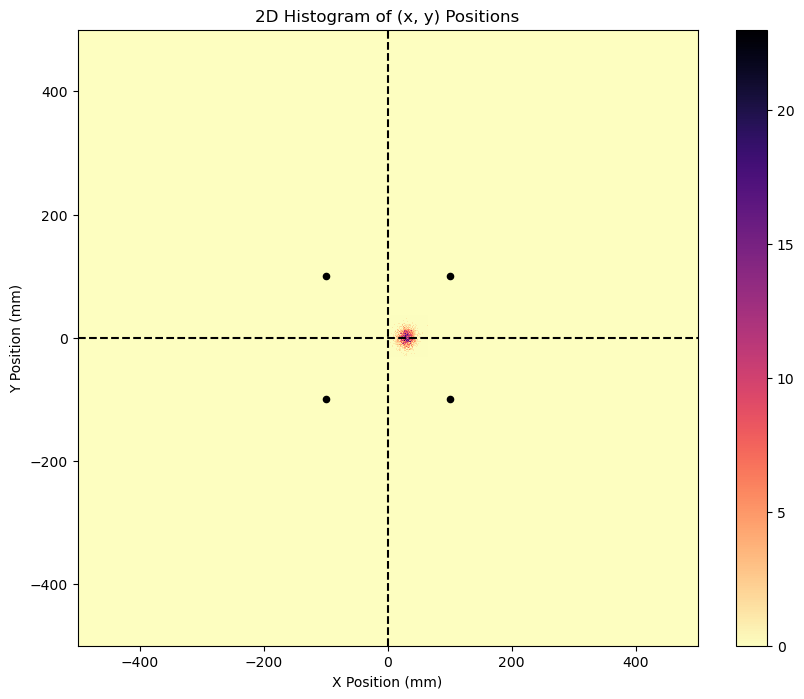

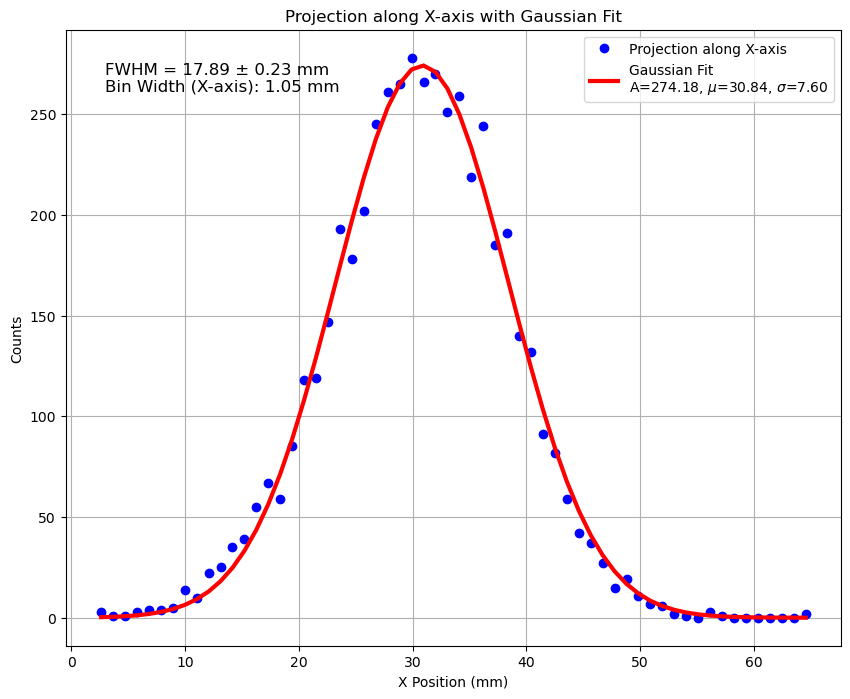

Chi-squared: 366.66
Degrees of freedom: 57
Critical value (df=57, alpha=0.05): 75.62
The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).


In [16]:
###More events
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_cells_fired(M, Nph):
    total_cells_fired = []
    for nph in Nph:
        total_cells_fired.append(round(M * (1 - math.exp(-nph / M))))
    return total_cells_fired

def calculate_total_charge_output(total_cells_fired, G, q):
    total_charge_output = [cells_fired * G * q for cells_fired in total_cells_fired]
    return total_charge_output

def read_Nph_from_file(filename):
    Nph_by_event = {}
    current_event = None
    event_counter = 0  # Counter to differentiate events with the same ID
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("Event ID"):
                event_id = float(line.split(":")[1].strip())
                if event_id in Nph_by_event:
                    event_id = f"{event_id}_{event_counter}"  # Append counter to make event IDs unique
                    event_counter += 1
                else:
                    event_counter = 0  # Reset counter when encountering a new event ID
                current_event = event_id
                Nph_by_event[current_event] = {0: 0, 1: 0, 2: 0, 3: 0}
            elif line.startswith("Detector ID"):
                parts = line.split(":")
                detector_id = int(float(parts[0].split()[-1]))
                Nph = float(parts[1].strip())
                if current_event in Nph_by_event:  
                    Nph_by_event[current_event][detector_id] = Nph
    return Nph_by_event

def calculate_position(Q_values, detector_positions):
    numerator_x = sum(Q_i**2 * pos[0] for Q_i, pos in zip(Q_values, detector_positions))
    numerator_y = sum(Q_i**2 * pos[1] for Q_i, pos in zip(Q_values, detector_positions))
    denominator = sum(Q_i**2 for Q_i in Q_values)

    x_position = numerator_x / denominator
    y_position = numerator_y / denominator

    return x_position, y_position

# Constants (MPPC S14160-6050HS)
M = 14331
G = 2.5e6  # G value
q = 1.6e-19  # charge of the electron value

# Detector positions
detector_positions = {
    0: (-10, 10),
    1: (-10, -10),
    2: (10, 10),
    3: (10, -10)
}

# Example usage:
filename = "/Users/rishaplamichhane/Downloads/MAPP_2_new copy/build_2/2.5 cm thickness/20 cm spacing/edge/1000_events_detector_id_counts_all_events.txt"  # Update with the filename generated from the previous code
Nph_by_event = read_Nph_from_file(filename)

# Calculate the total number of events
total_events = len(Nph_by_event)
print("Total number of events:", total_events)

x_values = []
y_values = []

for event_id, Nph_by_detector in Nph_by_event.items():
    total_fired = calculate_cells_fired(M, list(Nph_by_detector.values()))
    total_charge = calculate_total_charge_output(total_fired, G, q)
    detector_positions_sorted = [detector_positions[id] for id in sorted(Nph_by_detector.keys())]
    resulting_position = calculate_position(total_charge, detector_positions_sorted)
    x_values.append(resulting_position[0])
    y_values.append(resulting_position[1])
    
# Convert to NumPy arrays and multiply by 10 to convert from cm to mm
x_values_mm = np.array(x_values) * 10
y_values_mm = np.array(y_values) * 10

# Create a 2D histogram
plt.figure(figsize=(10, 8))
hist, x_edges, y_edges, _ =plt.hist2d(x_values_mm, y_values_mm, bins=60, cmap='magma_r')
cbar = plt.colorbar()
cbar.set_label('')  # Remove the label from the colorbar
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('2D Histogram of (x, y) Positions')
plt.grid(False)

plt.scatter([-100, -100, 100, 100], [100, -100, 100, -100], color='black', s=20)
    
# Add dashed lines for x and y axes
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.gca().set_facecolor('#FDFEC0')
plt.show()

# Create a 1D histogram projection along the X-axis
projection_x = np.sum(hist, axis=1)

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit Gaussian curve to the projection data
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2

# Initial guess for parameters
p0 = [max(projection_x), np.mean(x_bin_centers), (max(x_bin_centers) - min(x_bin_centers)) / 4]  

# Bounds for parameters (lower, upper)
bounds = ([0, min(x_bin_centers), 0], [np.inf, max(x_bin_centers), np.inf])  

popt, pcov = curve_fit(gaussian, x_bin_centers, projection_x, p0=p0, bounds=bounds)

# Plot the projection along X-axis
plt.figure(figsize=(10, 8))
plt.plot(x_bin_centers, projection_x, 'bo', label='Projection along X-axis')
plt.xlabel('X Position (mm)')
plt.ylabel('Counts')
plt.title('Projection along X-axis with Gaussian Fit')
plt.grid(True)

# Calculate bin width along X-axis
bin_width_x = x_edges[1] - x_edges[0]

# Plot Gaussian fit
plt.plot(x_bin_centers, gaussian(x_bin_centers, *popt), 'r-', linewidth=3, label=f'Gaussian Fit\nA={popt[0]:.2f}, $\mu$={popt[1]:.2f}, $\sigma$={popt[2]:.2f}')  # Set linewidth=2 (or any other suitable value)

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # FWHM = 2 * sqrt(2 * ln(2)) * sigma

# Estimate uncertainty in FWHM
sigma_uncertainty = np.sqrt(np.diag(pcov))[2]  # Standard deviation of sigma parameter
fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty  # Uncertainty in FWHM

# Add legend and annotate FWHM
plt.legend()
plt.annotate(f'FWHM = {fwhm:.2f} ± {fwhm_uncertainty:.2f} mm\nBin Width (X-axis): {bin_width_x:.2f} mm', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

plt.show()

# Perform chi-squared test
# Compute the expected values from the Gaussian fit
expected_counts = gaussian(x_bin_centers, *popt)

# Calculate the degrees of freedom
# Number of bins - number of parameters fitted (A, mu, sigma)
degrees_of_freedom = len(projection_x) - 3

# Calculate the chi-squared statistic
chi_squared = np.sum((projection_x - expected_counts)**2 / expected_counts)

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Determine the critical chi-squared value for your chosen significance level (e.g., 0.05)
critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

print(f"Critical value (df={degrees_of_freedom}, alpha=0.05): {critical_value:.2f}")

# Compare chi-squared statistic with critical value
if chi_squared < critical_value:
    print("The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).")
else:
    print("The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).")


In [ ]:
##15 cm spacing(0,0)

Total number of events: 5000


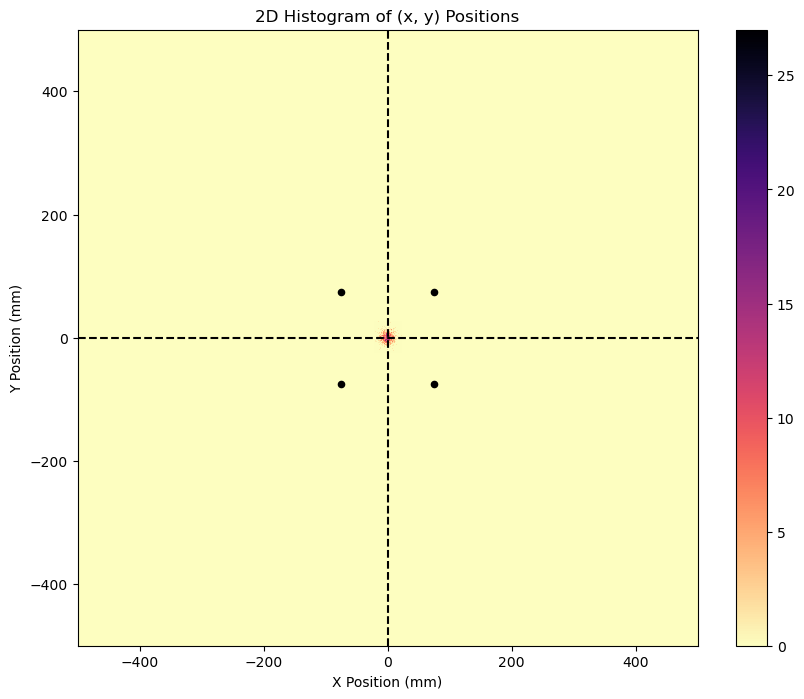

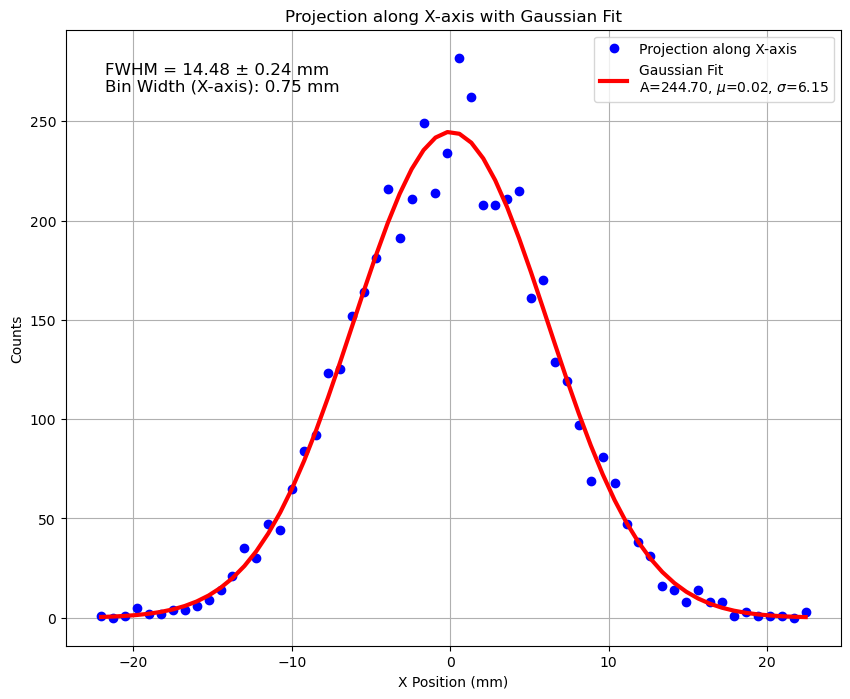

Chi-squared: 87.63
Degrees of freedom: 57
Critical value (df=57, alpha=0.05): 75.62
The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).


In [30]:
###More events
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_cells_fired(M, Nph):
    total_cells_fired = []
    for nph in Nph:
        total_cells_fired.append(round(M * (1 - math.exp(-nph / M))))
    return total_cells_fired

def calculate_total_charge_output(total_cells_fired, G, q):
    total_charge_output = [cells_fired * G * q for cells_fired in total_cells_fired]
    return total_charge_output

def read_Nph_from_file(filename):
    Nph_by_event = {}
    current_event = None
    event_counter = 0  # Counter to differentiate events with the same ID
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("Event ID"):
                event_id = float(line.split(":")[1].strip())
                if event_id in Nph_by_event:
                    event_id = f"{event_id}_{event_counter}"  # Append counter to make event IDs unique
                    event_counter += 1
                else:
                    event_counter = 0  # Reset counter when encountering a new event ID
                current_event = event_id
                Nph_by_event[current_event] = {0: 0, 1: 0, 2: 0, 3: 0}
            elif line.startswith("Detector ID"):
                parts = line.split(":")
                detector_id = int(float(parts[0].split()[-1]))
                Nph = float(parts[1].strip())
                if current_event in Nph_by_event:  
                    Nph_by_event[current_event][detector_id] = Nph
    return Nph_by_event

def calculate_position(Q_values, detector_positions):
    numerator_x = sum(Q_i**2 * pos[0] for Q_i, pos in zip(Q_values, detector_positions))
    numerator_y = sum(Q_i**2 * pos[1] for Q_i, pos in zip(Q_values, detector_positions))
    denominator = sum(Q_i**2 for Q_i in Q_values)

    x_position = numerator_x / denominator
    y_position = numerator_y / denominator

    return x_position, y_position

# Constants (MPPC S14160-6050HS)
M = 14331
G = 2.5e6  # G value
q = 1.6e-19  # charge of the electron value

# Detector positions
detector_positions = {
    0: (-7.5, 7.5),
    1: (-7.5, -7.5),
    2: (7.5, 7.5),
    3: (7.5, -7.5)
}

# Example usage:
filename = "/Users/rishaplamichhane/Downloads/MAPP_2_new copy/build_2/2.5 cm thickness/15 cm spacing/center/1000_events_detector_id_counts_all_events.txt"  # Update with the filename generated from the previous code
Nph_by_event = read_Nph_from_file(filename)

# Calculate the total number of events
total_events = len(Nph_by_event)
print("Total number of events:", total_events)

x_values = []
y_values = []

for event_id, Nph_by_detector in Nph_by_event.items():
    total_fired = calculate_cells_fired(M, list(Nph_by_detector.values()))
    total_charge = calculate_total_charge_output(total_fired, G, q)
    detector_positions_sorted = [detector_positions[id] for id in sorted(Nph_by_detector.keys())]
    resulting_position = calculate_position(total_charge, detector_positions_sorted)
    x_values.append(resulting_position[0])
    y_values.append(resulting_position[1])
    
# Convert to NumPy arrays and multiply by 10 to convert from cm to mm
x_values_mm = np.array(x_values) * 10
y_values_mm = np.array(y_values) * 10

# Create a 2D histogram
plt.figure(figsize=(10, 8))
hist, x_edges, y_edges, _ =plt.hist2d(x_values_mm, y_values_mm, bins=60, cmap='magma_r')
cbar = plt.colorbar()
cbar.set_label('')  # Remove the label from the colorbar
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('2D Histogram of (x, y) Positions')
plt.grid(False)

plt.scatter([-75, -75, 75, 75], [75, -75, 75, -75], color='black', s=20)
          
    
# Add dashed lines for x and y axes
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.gca().set_facecolor('#FDFEC0')
plt.show()

# Create a 1D histogram projection along the X-axis
projection_x = np.sum(hist, axis=1)

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit Gaussian curve to the projection data
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
p0 = [max(projection_x), np.mean(x_bin_centers), (max(x_bin_centers) - min(x_bin_centers)) / 4]  # Updated initial guess
bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Bounds for parameters (lower, upper)
popt, pcov = curve_fit(gaussian, x_bin_centers, projection_x, p0=p0, bounds=bounds)

# Plot the projection along X-axis
plt.figure(figsize=(10, 8))
plt.plot(x_bin_centers, projection_x, 'bo', label='Projection along X-axis')
plt.xlabel('X Position (mm)')
plt.ylabel('Counts')
plt.title('Projection along X-axis with Gaussian Fit')
plt.grid(True)

# Calculate bin width along X-axis
bin_width_x = x_edges[1] - x_edges[0]

# Plot Gaussian fit
plt.plot(x_bin_centers, gaussian(x_bin_centers, *popt), 'r-', linewidth=3, label=f'Gaussian Fit\nA={popt[0]:.2f}, $\mu$={popt[1]:.2f}, $\sigma$={popt[2]:.2f}')  # Set linewidth=2 (or any other suitable value)

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # FWHM = 2 * sqrt(2 * ln(2)) * sigma

# Estimate uncertainty in FWHM
sigma_uncertainty = np.sqrt(np.diag(pcov))[2]  # Standard deviation of sigma parameter
fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty  # Uncertainty in FWHM

# Add legend and annotate FWHM
plt.legend()
plt.annotate(f'FWHM = {fwhm:.2f} ± {fwhm_uncertainty:.2f} mm\nBin Width (X-axis): {bin_width_x:.2f} mm', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

plt.show()

# Perform chi-squared test
# Compute the expected values from the Gaussian fit
expected_counts = gaussian(x_bin_centers, *popt)

# Calculate the degrees of freedom
# Number of bins - number of parameters fitted (A, mu, sigma)
degrees_of_freedom = len(projection_x) - 3

# Calculate the chi-squared statistic
chi_squared = np.sum((projection_x - expected_counts)**2 / expected_counts)

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Determine the critical chi-squared value for your chosen significance level (e.g., 0.05)
critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

print(f"Critical value (df={degrees_of_freedom}, alpha=0.05): {critical_value:.2f}")

# Compare chi-squared statistic with critical value
if chi_squared < critical_value:
    print("The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).")
else:
    print("The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).")


In [ ]:
#15cm spacing (6,0)

Total number of events: 5000


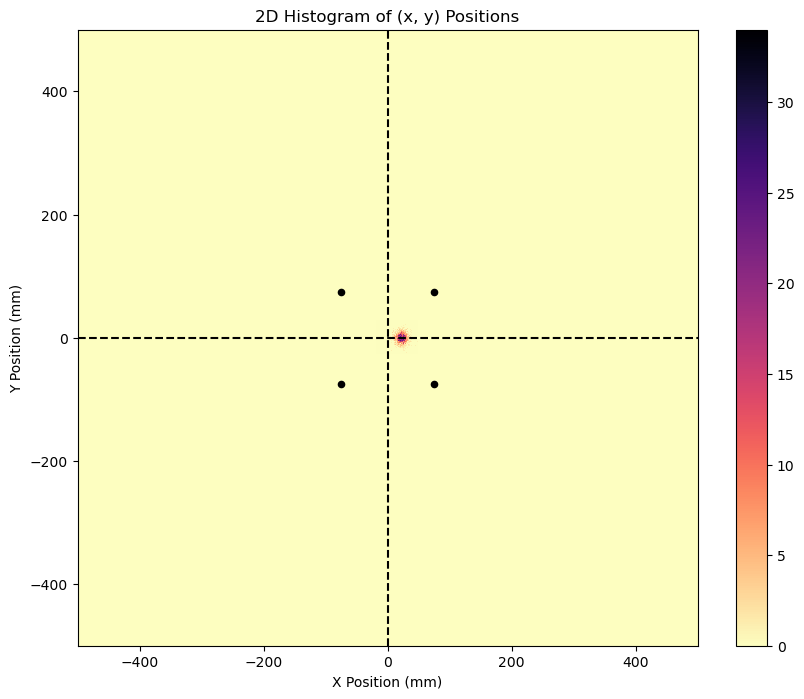

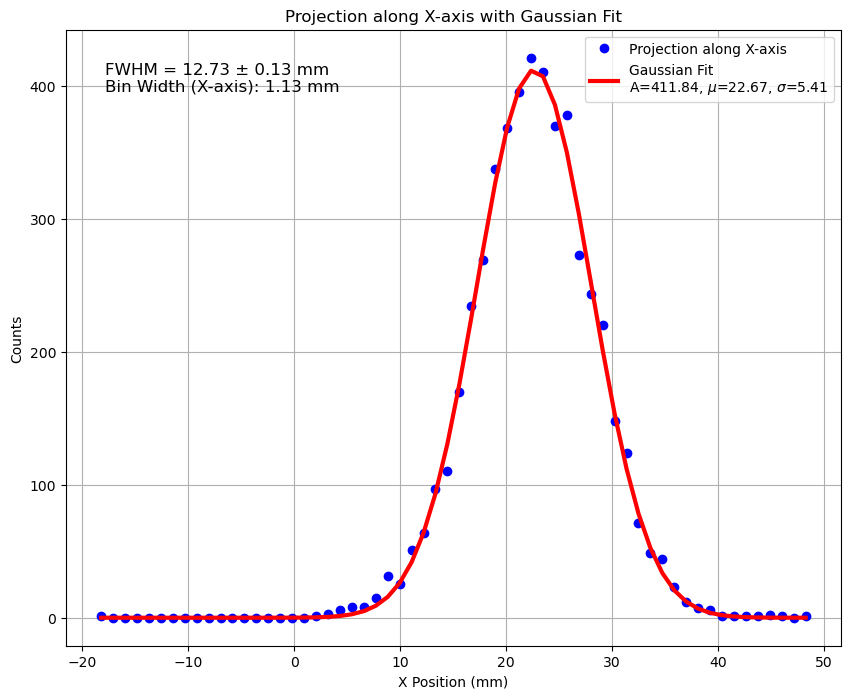

Chi-squared: 6326206171.17
Degrees of freedom: 57
Critical value (df=57, alpha=0.05): 75.62
The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).


In [22]:
###More events
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_cells_fired(M, Nph):
    total_cells_fired = []
    for nph in Nph:
        total_cells_fired.append(round(M * (1 - math.exp(-nph / M))))
    return total_cells_fired

def calculate_total_charge_output(total_cells_fired, G, q):
    total_charge_output = [cells_fired * G * q for cells_fired in total_cells_fired]
    return total_charge_output

def read_Nph_from_file(filename):
    Nph_by_event = {}
    current_event = None
    event_counter = 0  # Counter to differentiate events with the same ID
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("Event ID"):
                event_id = float(line.split(":")[1].strip())
                if event_id in Nph_by_event:
                    event_id = f"{event_id}_{event_counter}"  # Append counter to make event IDs unique
                    event_counter += 1
                else:
                    event_counter = 0  # Reset counter when encountering a new event ID
                current_event = event_id
                Nph_by_event[current_event] = {0: 0, 1: 0, 2: 0, 3: 0}
            elif line.startswith("Detector ID"):
                parts = line.split(":")
                detector_id = int(float(parts[0].split()[-1]))
                Nph = float(parts[1].strip())
                if current_event in Nph_by_event:  
                    Nph_by_event[current_event][detector_id] = Nph
    return Nph_by_event

def calculate_position(Q_values, detector_positions):
    numerator_x = sum(Q_i**2 * pos[0] for Q_i, pos in zip(Q_values, detector_positions))
    numerator_y = sum(Q_i**2 * pos[1] for Q_i, pos in zip(Q_values, detector_positions))
    denominator = sum(Q_i**2 for Q_i in Q_values)

    x_position = numerator_x / denominator
    y_position = numerator_y / denominator

    return x_position, y_position

# Constants (MPPC S14160-6050HS)
M = 14331
G = 2.5e6  # G value
q = 1.6e-19  # charge of the electron value

# Detector positions
detector_positions = {
    0: (-7.5, 7.5),
    1: (-7.5, -7.5),
    2: (7.5, 7.5),
    3: (7.5, -7.5)
}

# Example usage:
filename = "/Users/rishaplamichhane/Downloads/MAPP_2_new copy/build_2/2.5 cm thickness/15 cm spacing/edge/1000_events_detector_id_counts_all_events.txt"  # Update with the filename generated from the previous code
Nph_by_event = read_Nph_from_file(filename)

# Calculate the total number of events
total_events = len(Nph_by_event)
print("Total number of events:", total_events)

x_values = []
y_values = []

for event_id, Nph_by_detector in Nph_by_event.items():
    total_fired = calculate_cells_fired(M, list(Nph_by_detector.values()))
    total_charge = calculate_total_charge_output(total_fired, G, q)
    detector_positions_sorted = [detector_positions[id] for id in sorted(Nph_by_detector.keys())]
    resulting_position = calculate_position(total_charge, detector_positions_sorted)
    x_values.append(resulting_position[0])
    y_values.append(resulting_position[1])
    
# Convert to NumPy arrays and multiply by 10 to convert from cm to mm
x_values_mm = np.array(x_values) * 10
y_values_mm = np.array(y_values) * 10

# Create a 2D histogram
plt.figure(figsize=(10, 8))
hist, x_edges, y_edges, _ =plt.hist2d(x_values_mm, y_values_mm, bins=60, cmap='magma_r')
cbar = plt.colorbar()
cbar.set_label('')  # Remove the label from the colorbar
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('2D Histogram of (x, y) Positions')
plt.grid(False)

plt.scatter([-75, -75, 75, 75], [75, -75, 75, -75], color='black', s=20)
    
# Add dashed lines for x and y axes
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.gca().set_facecolor('#FDFEC0')
plt.show()

# Create a 1D histogram projection along the X-axis
projection_x = np.sum(hist, axis=1)

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit Gaussian curve to the projection data
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
projection_x = np.sum(hist, axis=1)

# Initial guess for parameters
p0 = [max(projection_x), np.mean(x_bin_centers), (max(x_bin_centers) - min(x_bin_centers)) / 4]  

# Bounds for parameters (lower, upper)
bounds = ([0, min(x_bin_centers), 0], [np.inf, max(x_bin_centers), np.inf])  

# Perform curve fitting with adjusted parameters
popt, pcov = curve_fit(gaussian, x_bin_centers, projection_x, p0=p0, bounds=bounds)

# Plot the projection along X-axis
plt.figure(figsize=(10, 8))
plt.plot(x_bin_centers, projection_x, 'bo', label='Projection along X-axis')
plt.xlabel('X Position (mm)')
plt.ylabel('Counts')
plt.title('Projection along X-axis with Gaussian Fit')
plt.grid(True)

# Calculate bin width along X-axis
bin_width_x = x_edges[1] - x_edges[0]

# Plot Gaussian fit
plt.plot(x_bin_centers, gaussian(x_bin_centers, *popt), 'r-', linewidth=3, label=f'Gaussian Fit\nA={popt[0]:.2f}, $\mu$={popt[1]:.2f}, $\sigma$={popt[2]:.2f}')  # Set linewidth=2 (or any other suitable value)

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # FWHM = 2 * sqrt(2 * ln(2)) * sigma

# Estimate uncertainty in FWHM
sigma_uncertainty = np.sqrt(np.diag(pcov))[2]  # Standard deviation of sigma parameter
fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty  # Uncertainty in FWHM

# Add legend and annotate FWHM
plt.legend()
plt.annotate(f'FWHM = {fwhm:.2f} ± {fwhm_uncertainty:.2f} mm\nBin Width (X-axis): {bin_width_x:.2f} mm', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

plt.show()

# Perform chi-squared test
# Compute the expected values from the Gaussian fit
expected_counts = gaussian(x_bin_centers, *popt)

# Calculate the degrees of freedom
# Number of bins - number of parameters fitted (A, mu, sigma)
degrees_of_freedom = len(projection_x) - 3

# Calculate the chi-squared statistic
chi_squared = np.sum((projection_x - expected_counts)**2 / expected_counts)

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Determine the critical chi-squared value for your chosen significance level (e.g., 0.05)
critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

print(f"Critical value (df={degrees_of_freedom}, alpha=0.05): {critical_value:.2f}")

# Compare chi-squared statistic with critical value
if chi_squared < critical_value:
    print("The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).")
else:
    print("The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).")


In [ ]:
##10 cm spacing(0,0)

Total number of events: 5000


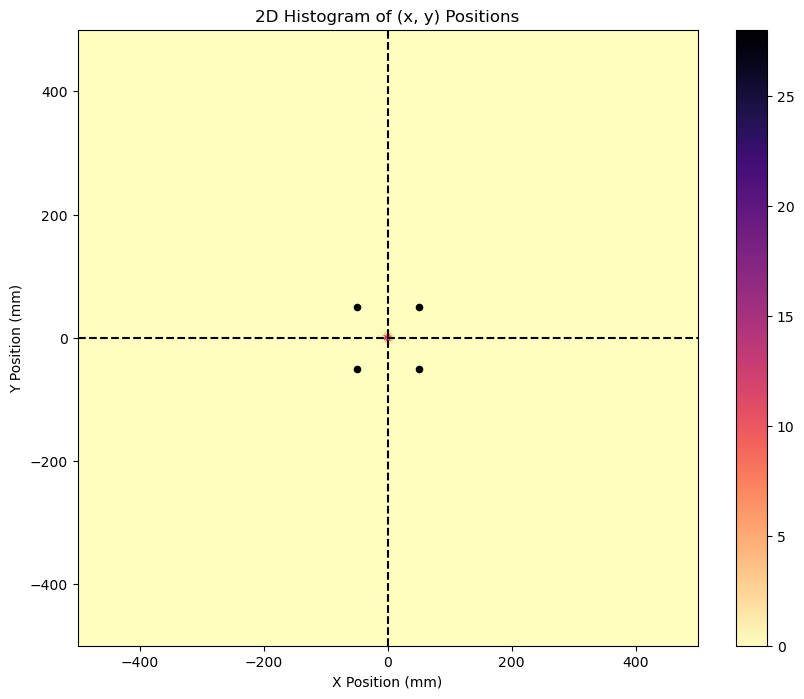

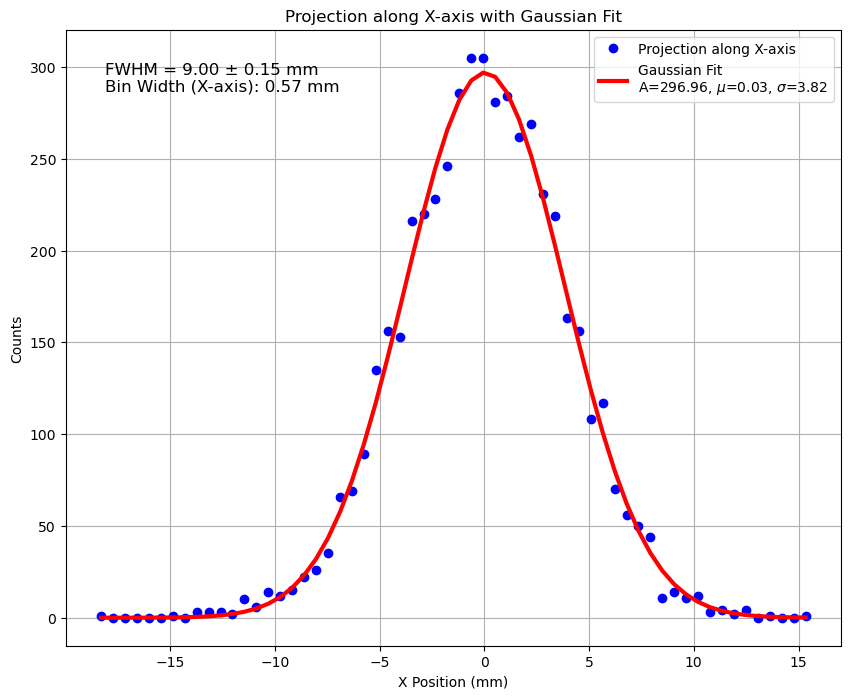

Chi-squared: 432.76
Degrees of freedom: 57
Critical value (df=57, alpha=0.05): 75.62
The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).


In [77]:
###More events
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_cells_fired(M, Nph):
    total_cells_fired = []
    for nph in Nph:
        total_cells_fired.append(round(M * (1 - math.exp(-nph / M))))
    return total_cells_fired

def calculate_total_charge_output(total_cells_fired, G, q):
    total_charge_output = [cells_fired * G * q for cells_fired in total_cells_fired]
    return total_charge_output

def read_Nph_from_file(filename):
    Nph_by_event = {}
    current_event = None
    event_counter = 0  # Counter to differentiate events with the same ID
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("Event ID"):
                event_id = float(line.split(":")[1].strip())
                if event_id in Nph_by_event:
                    event_id = f"{event_id}_{event_counter}"  # Append counter to make event IDs unique
                    event_counter += 1
                else:
                    event_counter = 0  # Reset counter when encountering a new event ID
                current_event = event_id
                Nph_by_event[current_event] = {0: 0, 1: 0, 2: 0, 3: 0}
            elif line.startswith("Detector ID"):
                parts = line.split(":")
                detector_id = int(float(parts[0].split()[-1]))
                Nph = float(parts[1].strip())
                if current_event in Nph_by_event:  
                    Nph_by_event[current_event][detector_id] = Nph
    return Nph_by_event

def calculate_position(Q_values, detector_positions):
    numerator_x = sum(Q_i**2 * pos[0] for Q_i, pos in zip(Q_values, detector_positions))
    numerator_y = sum(Q_i**2 * pos[1] for Q_i, pos in zip(Q_values, detector_positions))
    denominator = sum(Q_i**2 for Q_i in Q_values)

    x_position = numerator_x / denominator
    y_position = numerator_y / denominator

    return x_position, y_position

# Constants (MPPC S14160-6050HS)
M = 14331
G = 2.5e6  # G value
q = 1.6e-19  # charge of the electron value

# Detector positions
detector_positions = {
    0: (-5, 5),
    1: (-5, -5),
    2: (5, 5),
    3: (5, -5)
}

# Example usage:
filename = "/Users/rishaplamichhane/Downloads/MAPP_2_new copy/build_2/2.5 cm thickness/10 cm spacing/center/1000_events_detector_id_counts_all_events.txt"  # Update with the filename generated from the previous code
Nph_by_event = read_Nph_from_file(filename)

# Calculate the total number of events
total_events = len(Nph_by_event)
print("Total number of events:", total_events)

x_values = []
y_values = []

for event_id, Nph_by_detector in Nph_by_event.items():
    total_fired = calculate_cells_fired(M, list(Nph_by_detector.values()))
    total_charge = calculate_total_charge_output(total_fired, G, q)
    detector_positions_sorted = [detector_positions[id] for id in sorted(Nph_by_detector.keys())]
    resulting_position = calculate_position(total_charge, detector_positions_sorted)
    x_values.append(resulting_position[0])
    y_values.append(resulting_position[1])
    
# Convert to NumPy arrays and multiply by 10 to convert from cm to mm
x_values_mm = np.array(x_values) * 10
y_values_mm = np.array(y_values) * 10

# Create a 2D histogram
plt.figure(figsize=(10, 8))
hist, x_edges, y_edges, _ =plt.hist2d(x_values_mm, y_values_mm, bins=60, cmap='magma_r')
cbar = plt.colorbar()
cbar.set_label('')  # Remove the label from the colorbar
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('2D Histogram of (x, y) Positions')
plt.grid(False)

plt.scatter([-50, -50, 50, 50], [50, -50, 50, -50], color='black', s=20)
    
# Add dashed lines for x and y axes
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.gca().set_facecolor('#FDFEC0')
plt.show()

# Create a 1D histogram projection along the X-axis
projection_x = np.sum(hist, axis=1)

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit Gaussian curve to the projection data with restricted range and bounds
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
restricted_range = (np.abs(x_bin_centers) <= 10)  # Restricting to ±30 mm
x_bin_centers_restricted = x_bin_centers[restricted_range]
projection_x_restricted = projection_x[restricted_range]
p0 = [max(projection_x_restricted), np.mean(x_bin_centers_restricted), (max(x_bin_centers_restricted) - min(x_bin_centers_restricted)) / 4]  # Updated initial guess
bounds = ([0, -10, 0], [np.inf, 15, np.inf])  # Bounds for parameters (lower, upper)
popt, pcov = curve_fit(gaussian, x_bin_centers_restricted, projection_x_restricted, p0=p0, bounds=bounds)

# Plot the projection along X-axis
plt.figure(figsize=(10, 8))
plt.plot(x_bin_centers, projection_x, 'bo', label='Projection along X-axis')
plt.xlabel('X Position (mm)')
plt.ylabel('Counts')
plt.title('Projection along X-axis with Gaussian Fit')
plt.grid(True)

# Calculate bin width along X-axis
bin_width_x = x_edges[1] - x_edges[0]

# Plot Gaussian fit
plt.plot(x_bin_centers, gaussian(x_bin_centers, *popt), 'r-', linewidth=3, label=f'Gaussian Fit\nA={popt[0]:.2f}, $\mu$={popt[1]:.2f}, $\sigma$={popt[2]:.2f}')  # Set linewidth=2 (or any other suitable value)

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # FWHM = 2 * sqrt(2 * ln(2)) * sigma

# Estimate uncertainty in FWHM
sigma_uncertainty = np.sqrt(np.diag(pcov))[2]  # Standard deviation of sigma parameter
fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty  # Uncertainty in FWHM

# Add legend and annotate FWHM
plt.legend()
plt.annotate(f'FWHM = {fwhm:.2f} ± {fwhm_uncertainty:.2f} mm\nBin Width (X-axis): {bin_width_x:.2f} mm', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

plt.show()

# Perform chi-squared test
# Compute the expected values from the Gaussian fit
expected_counts = gaussian(x_bin_centers, *popt)

# Calculate the degrees of freedom
# Number of bins - number of parameters fitted (A, mu, sigma)
degrees_of_freedom = len(projection_x) - 3

# Calculate the chi-squared statistic
chi_squared = np.sum((projection_x - expected_counts)**2 / expected_counts)

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Determine the critical chi-squared value for your chosen significance level (e.g., 0.05)
critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

print(f"Critical value (df={degrees_of_freedom}, alpha=0.05): {critical_value:.2f}")

# Compare chi-squared statistic with critical value
if chi_squared < critical_value:
    print("The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).")
else:
    print("The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).")


In [ ]:
##10 cm spacing (4,0)

Total number of events: 5000


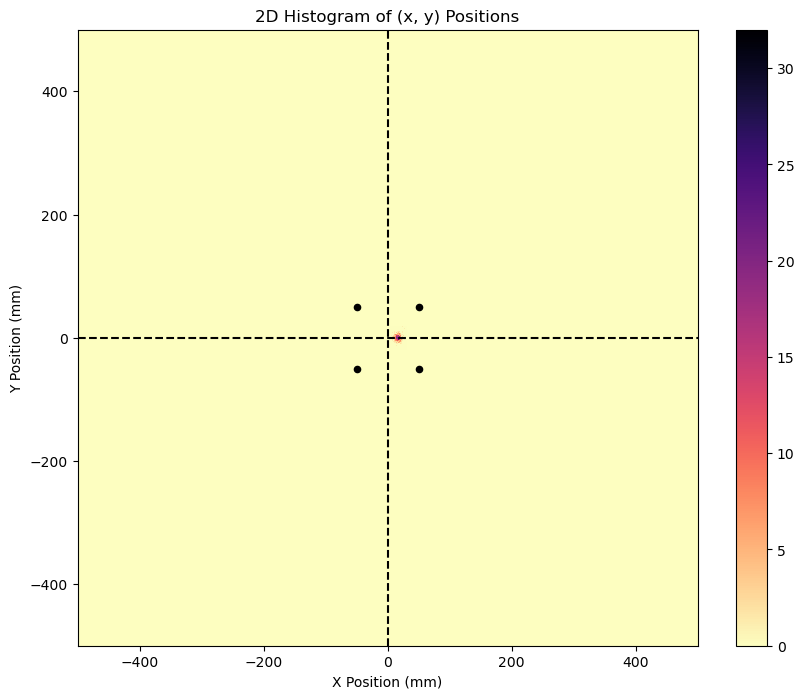

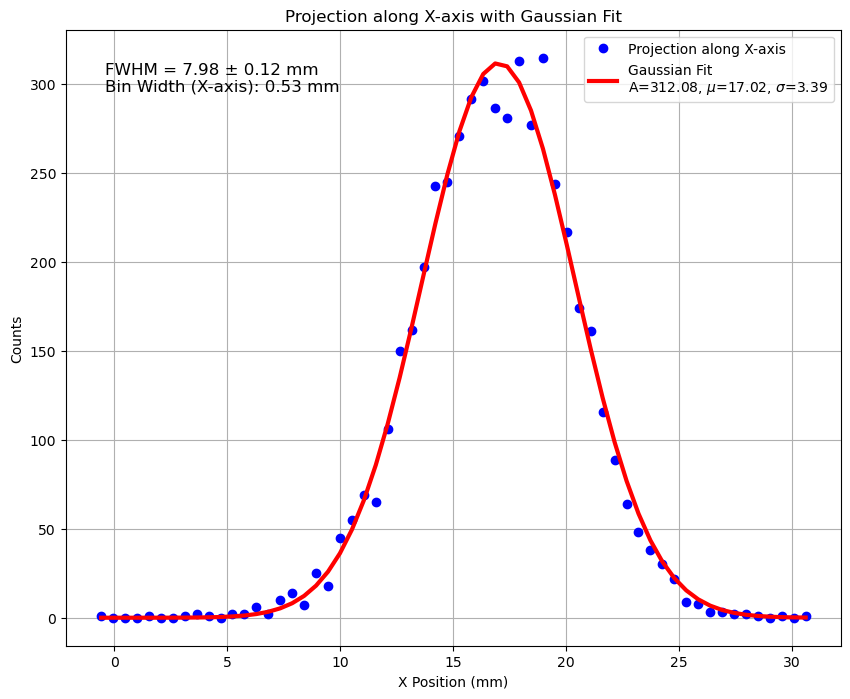

Chi-squared: 2590.34
Degrees of freedom: 57
Critical value (df=57, alpha=0.05): 75.62
The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).


In [24]:
###More events
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_cells_fired(M, Nph):
    total_cells_fired = []
    for nph in Nph:
        total_cells_fired.append(round(M * (1 - math.exp(-nph / M))))
    return total_cells_fired

def calculate_total_charge_output(total_cells_fired, G, q):
    total_charge_output = [cells_fired * G * q for cells_fired in total_cells_fired]
    return total_charge_output

def read_Nph_from_file(filename):
    Nph_by_event = {}
    current_event = None
    event_counter = 0  # Counter to differentiate events with the same ID
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("Event ID"):
                event_id = float(line.split(":")[1].strip())
                if event_id in Nph_by_event:
                    event_id = f"{event_id}_{event_counter}"  # Append counter to make event IDs unique
                    event_counter += 1
                else:
                    event_counter = 0  # Reset counter when encountering a new event ID
                current_event = event_id
                Nph_by_event[current_event] = {0: 0, 1: 0, 2: 0, 3: 0}
            elif line.startswith("Detector ID"):
                parts = line.split(":")
                detector_id = int(float(parts[0].split()[-1]))
                Nph = float(parts[1].strip())
                if current_event in Nph_by_event:  
                    Nph_by_event[current_event][detector_id] = Nph
    return Nph_by_event

def calculate_position(Q_values, detector_positions):
    numerator_x = sum(Q_i**2 * pos[0] for Q_i, pos in zip(Q_values, detector_positions))
    numerator_y = sum(Q_i**2 * pos[1] for Q_i, pos in zip(Q_values, detector_positions))
    denominator = sum(Q_i**2 for Q_i in Q_values)

    x_position = numerator_x / denominator
    y_position = numerator_y / denominator

    return x_position, y_position

# Constants (MPPC S14160-6050HS)
M = 14331
G = 2.5e6  # G value
q = 1.6e-19  # charge of the electron value

# Detector positions
detector_positions = {
    0: (-5, 5),
    1: (-5, -5),
    2: (5, 5),
    3: (5, -5)
}

# Example usage:
filename = "/Users/rishaplamichhane/Downloads/MAPP_2_new copy/build_2/2.5 cm thickness/10 cm spacing/edge/1000_events_detector_id_counts_all_events.txt"  # Update with the filename generated from the previous code
Nph_by_event = read_Nph_from_file(filename)

# Calculate the total number of events
total_events = len(Nph_by_event)
print("Total number of events:", total_events)

x_values = []
y_values = []

for event_id, Nph_by_detector in Nph_by_event.items():
    total_fired = calculate_cells_fired(M, list(Nph_by_detector.values()))
    total_charge = calculate_total_charge_output(total_fired, G, q)
    detector_positions_sorted = [detector_positions[id] for id in sorted(Nph_by_detector.keys())]
    resulting_position = calculate_position(total_charge, detector_positions_sorted)
    x_values.append(resulting_position[0])
    y_values.append(resulting_position[1])
    
# Convert to NumPy arrays and multiply by 10 to convert from cm to mm
x_values_mm = np.array(x_values) * 10
y_values_mm = np.array(y_values) * 10

# Create a 2D histogram
plt.figure(figsize=(10, 8))
hist, x_edges, y_edges, _ =plt.hist2d(x_values_mm, y_values_mm, bins=60, cmap='magma_r')
cbar = plt.colorbar()
cbar.set_label('')  # Remove the label from the colorbar
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('2D Histogram of (x, y) Positions')
plt.grid(False)

plt.scatter([-50, -50, 50, 50], [50, -50, 50, -50], color='black', s=20)
    
# Add dashed lines for x and y axes
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.gca().set_facecolor('#FDFEC0')
plt.show()

# Create a 1D histogram projection along the X-axis
projection_x = np.sum(hist, axis=1)

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit Gaussian curve to the projection data
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
# Initial guess for parameters
p0 = [max(projection_x), np.mean(x_bin_centers), (max(x_bin_centers) - min(x_bin_centers)) / 4]  

# Bounds for parameters (lower, upper)
bounds = ([0, min(x_bin_centers), 0], [np.inf, max(x_bin_centers), np.inf])  
popt, pcov = curve_fit(gaussian, x_bin_centers, projection_x, p0=p0, bounds=bounds)

# Plot the projection along X-axis
plt.figure(figsize=(10, 8))
plt.plot(x_bin_centers, projection_x, 'bo', label='Projection along X-axis')
plt.xlabel('X Position (mm)')
plt.ylabel('Counts')
plt.title('Projection along X-axis with Gaussian Fit')
plt.grid(True)

# Calculate bin width along X-axis
bin_width_x = x_edges[1] - x_edges[0]

# Plot Gaussian fit
plt.plot(x_bin_centers, gaussian(x_bin_centers, *popt), 'r-', linewidth=3, label=f'Gaussian Fit\nA={popt[0]:.2f}, $\mu$={popt[1]:.2f}, $\sigma$={popt[2]:.2f}')  # Set linewidth=2 (or any other suitable value)

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # FWHM = 2 * sqrt(2 * ln(2)) * sigma

# Estimate uncertainty in FWHM
sigma_uncertainty = np.sqrt(np.diag(pcov))[2]  # Standard deviation of sigma parameter
fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty  # Uncertainty in FWHM

# Add legend and annotate FWHM
plt.legend()
plt.annotate(f'FWHM = {fwhm:.2f} ± {fwhm_uncertainty:.2f} mm\nBin Width (X-axis): {bin_width_x:.2f} mm', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

plt.show()

# Perform chi-squared test
# Compute the expected values from the Gaussian fit
expected_counts = gaussian(x_bin_centers, *popt)

# Calculate the degrees of freedom
# Number of bins - number of parameters fitted (A, mu, sigma)
degrees_of_freedom = len(projection_x) - 3

# Calculate the chi-squared statistic
chi_squared = np.sum((projection_x - expected_counts)**2 / expected_counts)

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Determine the critical chi-squared value for your chosen significance level (e.g., 0.05)
critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

print(f"Critical value (df={degrees_of_freedom}, alpha=0.05): {critical_value:.2f}")

# Compare chi-squared statistic with critical value
if chi_squared < critical_value:
    print("The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).")
else:
    print("The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).")


In [ ]:
##25 cm spacing(0, 0)


Total number of events: 5000


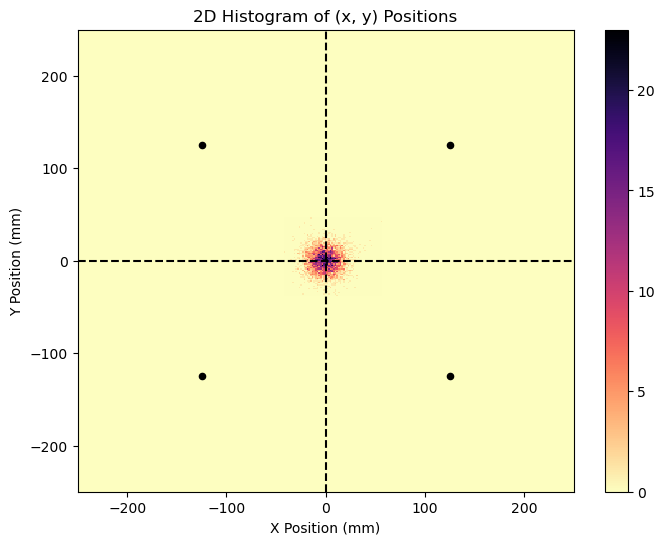

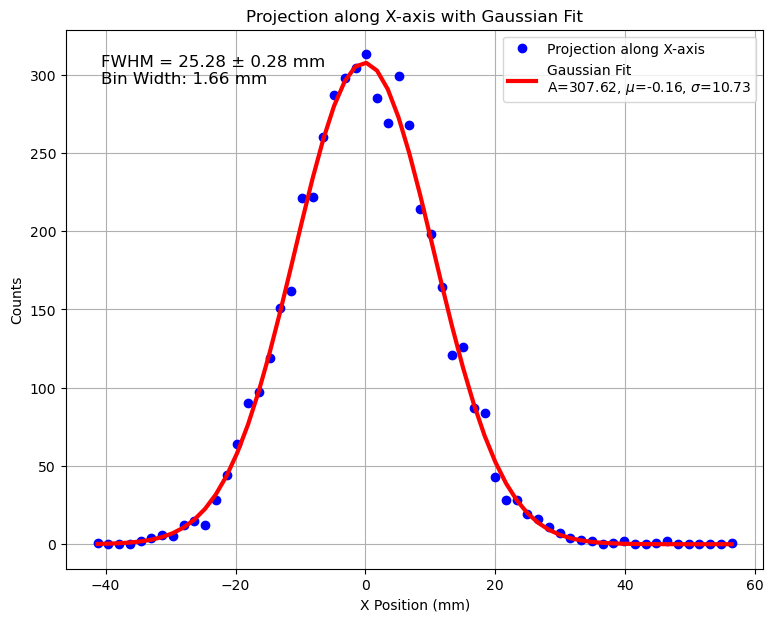

Chi-squared: 3751.23
Degrees of freedom: 57
Critical value (df=57, alpha=0.05): 75.62
The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).


In [78]:
###More events
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_cells_fired(M, Nph):
    total_cells_fired = []
    for nph in Nph:
        total_cells_fired.append(round(M * (1 - math.exp(-nph / M))))
    return total_cells_fired

def calculate_total_charge_output(total_cells_fired, G, q):
    total_charge_output = [cells_fired * G * q for cells_fired in total_cells_fired]
    return total_charge_output

def read_Nph_from_file(filename):
    Nph_by_event = {}
    current_event = None
    event_counter = 0  # Counter to differentiate events with the same ID
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("Event ID"):
                event_id = float(line.split(":")[1].strip())
                if event_id in Nph_by_event:
                    event_id = f"{event_id}_{event_counter}"  # Append counter to make event IDs unique
                    event_counter += 1
                else:
                    event_counter = 0  # Reset counter when encountering a new event ID
                current_event = event_id
                Nph_by_event[current_event] = {0: 0, 1: 0, 2: 0, 3: 0}
            elif line.startswith("Detector ID"):
                parts = line.split(":")
                detector_id = int(float(parts[0].split()[-1]))
                Nph = float(parts[1].strip())
                if current_event in Nph_by_event:  
                    Nph_by_event[current_event][detector_id] = Nph
    return Nph_by_event


def calculate_position(Q_values, detector_positions):
    numerator_x = sum(Q_i**2 * pos[0] for Q_i, pos in zip(Q_values, detector_positions))
    numerator_y = sum(Q_i**2 * pos[1] for Q_i, pos in zip(Q_values, detector_positions))
    denominator = sum(Q_i**2 for Q_i in Q_values)

    x_position = numerator_x / denominator
    y_position = numerator_y / denominator

    return x_position, y_position

# Constants (MPPC S14160-6050HS)
M = 14331
G = 2.5e6  # G value
q = 1.6e-19  # charge of the electron value

# Detector positions
detector_positions = {
    0: (-12.5, 12.5),
    1: (-12.5, -12.5),
    2: (12.5, 12.5),
    3: (12.5, -12.5)
}

# Example usage:
filename = "/Users/rishaplamichhane/Downloads/MAPP_2_new copy/build_2/2.5 cm thickness/25 cm spacing/center/1000_events_detector_id_counts_all_events.txt"  # Update with the filename generated from the previous code

Nph_by_event = read_Nph_from_file(filename)
# Calculate the total number of events
total_events = len(Nph_by_event)
print("Total number of events:", total_events)

x_values = []
y_values = []

for event_id, Nph_by_detector in Nph_by_event.items():
    total_fired = calculate_cells_fired(M, list(Nph_by_detector.values()))
    total_charge = calculate_total_charge_output(total_fired, G, q)
    detector_positions_sorted = [detector_positions[id] for id in sorted(Nph_by_detector.keys())]
    resulting_position = calculate_position(total_charge, detector_positions_sorted)
    x_values.append(resulting_position[0])
    y_values.append(resulting_position[1])
    
# Convert to NumPy arrays and multiply by 10 to convert from cm to mm
x_values_mm = np.array(x_values) * 10
y_values_mm = np.array(y_values) * 10

# Create a 2D histogram
plt.figure(figsize=(8, 6))
hist, x_edges, y_edges, _ =plt.hist2d(x_values_mm, y_values_mm, bins=60, cmap='magma_r')
cbar = plt.colorbar()
cbar.set_label('')  # Remove the label from the colorbar
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('2D Histogram of (x, y) Positions')
plt.grid(False)

plt.scatter([-125, -125, 125, 125], [125, -125, 125, -125], color='black', s=20)
    
# Add dashed lines for x and y axes
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlim(-250, 250)
plt.ylim(-250, 250)
plt.gca().set_facecolor('#FDFEC0')
plt.show()

# Create a 1D histogram projection along the X-axis
projection_x = np.sum(hist, axis=1)

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit Gaussian curve to the projection data
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
p0 = [max(projection_x), np.mean(x_bin_centers), (max(x_bin_centers) - min(x_bin_centers)) / 4]  # Updated initial guess
bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Bounds for parameters (lower, upper)
popt, pcov = curve_fit(gaussian, x_bin_centers, projection_x, p0=p0, bounds=bounds)

# Plot the projection along X-axis
plt.figure(figsize=(9, 7))
plt.plot(x_bin_centers, projection_x, 'bo', label='Projection along X-axis')
plt.xlabel('X Position (mm)')
plt.ylabel('Counts')
plt.title('Projection along X-axis with Gaussian Fit')
plt.grid(True)

# Calculate bin width along X-axis
bin_width_x = x_edges[1] - x_edges[0]

# Plot Gaussian fit
plt.plot(x_bin_centers, gaussian(x_bin_centers, *popt), 'r-', linewidth=3, label=f'Gaussian Fit\nA={popt[0]:.2f}, $\mu$={popt[1]:.2f}, $\sigma$={popt[2]:.2f}')  # Set linewidth=2 (or any other suitable value)

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # FWHM = 2 * sqrt(2 * ln(2)) * sigma

# Estimate uncertainty in FWHM
sigma_uncertainty = np.sqrt(np.diag(pcov))[2]  # Standard deviation of sigma parameter
fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty  # Uncertainty in FWHM

# Add legend and annotate FWHM
plt.legend()
plt.annotate(f'FWHM = {fwhm:.2f} ± {fwhm_uncertainty:.2f} mm\nBin Width: {bin_width_x:.2f} mm', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

plt.show()

# Perform chi-squared test
# Compute the expected values from the Gaussian fit
expected_counts = gaussian(x_bin_centers, *popt)

# Calculate the degrees of freedom
# Number of bins - number of parameters fitted (A, mu, sigma)
degrees_of_freedom = len(projection_x) - 3

# Calculate the chi-squared statistic
chi_squared = np.sum((projection_x - expected_counts)**2 / expected_counts)

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Determine the critical chi-squared value for your chosen significance level (e.g., 0.05)
critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

print(f"Critical value (df={degrees_of_freedom}, alpha=0.05): {critical_value:.2f}")

# Compare chi-squared statistic with critical value
if chi_squared < critical_value:
    print("The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).")
else:
    print("The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).")


In [ ]:
##Tests


Total number of events: 5000


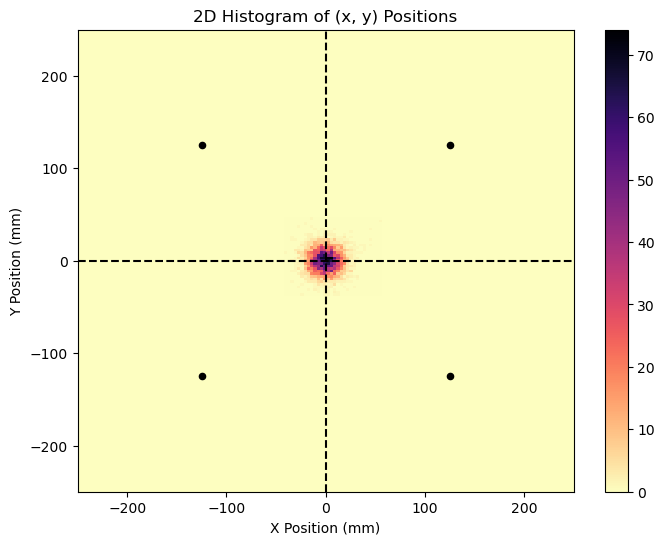

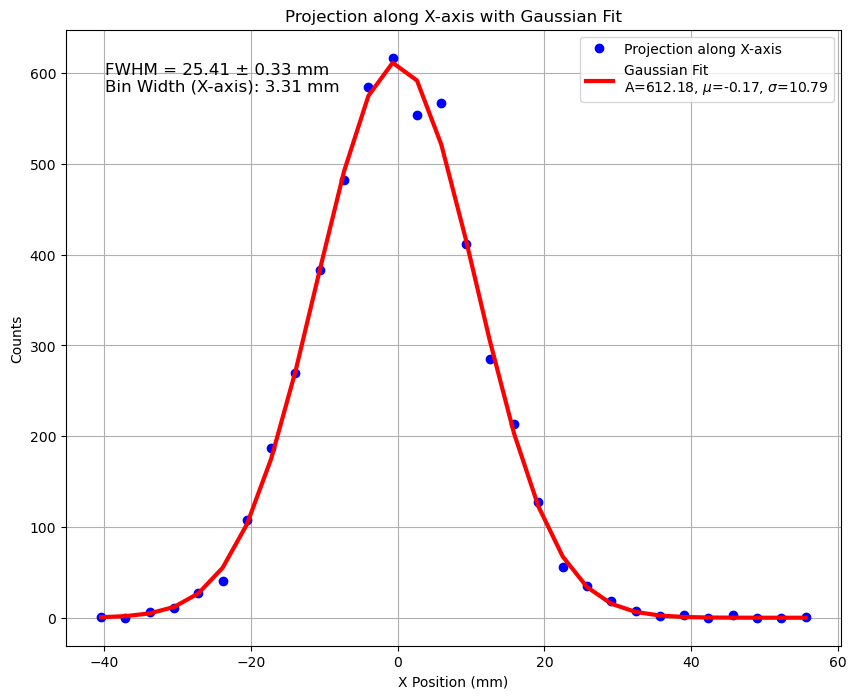

Chi-squared: 1174.69
Degrees of freedom: 27
Critical value (df=27, alpha=0.05): 40.11
The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).


In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

def calculate_cells_fired(M, Nph):
    total_cells_fired = []
    for nph in Nph:
        total_cells_fired.append(round(M * (1 - math.exp(-nph / M))))
    return total_cells_fired

def calculate_total_charge_output(total_cells_fired, G, q):
    total_charge_output = [cells_fired * G * q for cells_fired in total_cells_fired]
    return total_charge_output

def read_Nph_from_file(filename):
    Nph_by_event = {}
    current_event = None
    event_counter = 0  # Counter to differentiate events with the same ID
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("Event ID"):
                event_id = float(line.split(":")[1].strip())
                if event_id in Nph_by_event:
                    event_id = f"{event_id}_{event_counter}"  # Append counter to make event IDs unique
                    event_counter += 1
                else:
                    event_counter = 0  # Reset counter when encountering a new event ID
                current_event = event_id
                Nph_by_event[current_event] = {0: 0, 1: 0, 2: 0, 3: 0}
            elif line.startswith("Detector ID"):
                parts = line.split(":")
                detector_id = int(float(parts[0].split()[-1]))
                Nph = float(parts[1].strip())
                if current_event in Nph_by_event:  
                    Nph_by_event[current_event][detector_id] = Nph
    return Nph_by_event

def calculate_position(Q_values, detector_positions):
    numerator_x = sum(Q_i**2 * pos[0] for Q_i, pos in zip(Q_values, detector_positions))
    numerator_y = sum(Q_i**2 * pos[1] for Q_i, pos in zip(Q_values, detector_positions))
    denominator = sum(Q_i**2 for Q_i in Q_values)

    x_position = numerator_x / denominator
    y_position = numerator_y / denominator

    return x_position, y_position

# Constants (MPPC S14160-6050HS)
M = 14331
G = 2.5e6  # G value
q = 1.6e-19  # charge of the electron value

# Detector positions
detector_positions = {
    0: (-12.5, 12.5),
    1: (-12.5, -12.5),
    2: (12.5, 12.5),
    3: (12.5, -12.5)
}

# Example usage:
filename = "/Users/rishaplamichhane/Downloads/MAPP_2_new copy/build_2/2.5 cm thickness/25 cm spacing/center/1000_events_detector_id_counts_all_events.txt"  # Update with the filename generated from the previous code

Nph_by_event = read_Nph_from_file(filename)
# Calculate the total number of events
total_events = len(Nph_by_event)
print("Total number of events:", total_events)

x_values = []
y_values = []

for event_id, Nph_by_detector in Nph_by_event.items():
    total_fired = calculate_cells_fired(M, list(Nph_by_detector.values()))
    total_charge = calculate_total_charge_output(total_fired, G, q)
    detector_positions_sorted = [detector_positions[id] for id in sorted(Nph_by_detector.keys())]
    resulting_position = calculate_position(total_charge, detector_positions_sorted)
    x_values.append(resulting_position[0])
    y_values.append(resulting_position[1])
    
# Convert to NumPy arrays and multiply by 10 to convert from cm to mm
x_values_mm = np.array(x_values) * 10
y_values_mm = np.array(y_values) * 10

# Create a 2D histogram
plt.figure(figsize=(8, 6))
hist, x_edges, y_edges, _ =plt.hist2d(x_values_mm, y_values_mm, bins=60, cmap='magma_r')
cbar = plt.colorbar()
cbar.set_label('')  # Remove the label from the colorbar
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('2D Histogram of (x, y) Positions')
plt.grid(False)

plt.scatter([-125, -125, 125, 125], [125, -125, 125, -125], color='black', s=20)
    
# Add dashed lines for x and y axes
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlim(-250, 250)
plt.ylim(-250, 250)
plt.gca().set_facecolor('#FDFEC0')

# Calculate bin width along X-axis
bin_width_x = x_edges[1] - x_edges[0]

# Create a 1D histogram projection along the X-axis
projection_x = np.sum(hist, axis=1)

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit Gaussian curve to the projection data
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
p0 = [max(projection_x), np.mean(x_bin_centers), (max(x_bin_centers) - min(x_bin_centers)) / 4]  # Updated initial guess
bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Bounds for parameters (lower, upper)
popt, pcov = curve_fit(gaussian, x_bin_centers, projection_x, p0=p0, bounds=bounds)

# Plot the projection along X-axis
plt.figure(figsize=(10, 8))
plt.plot(x_bin_centers, projection_x, 'bo', label='Projection along X-axis')
plt.xlabel('X Position (mm)')
plt.ylabel('Counts')
plt.title('Projection along X-axis with Gaussian Fit')
plt.grid(True)

# Plot Gaussian fit
plt.plot(x_bin_centers, gaussian(x_bin_centers, *popt), 'r-', linewidth=3, label=f'Gaussian Fit\nA={popt[0]:.2f}, $\mu$={popt[1]:.2f}, $\sigma$={popt[2]:.2f}')  # Set linewidth=2 (or any other suitable value)

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # FWHM = 2 * sqrt(2 * ln(2)) * sigma

# Estimate uncertainty in FWHM
sigma_uncertainty = np.sqrt(np.diag(pcov))[2]  # Standard deviation of sigma parameter
fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty  # Uncertainty in FWHM

# Add legend and annotate FWHM
plt.legend()
plt.annotate(f'FWHM = {fwhm:.2f} ± {fwhm_uncertainty:.2f} mm\nBin Width (X-axis): {bin_width_x:.2f} mm', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

plt.show()

# Perform chi-squared test
# Compute the expected values from the Gaussian fit
expected_counts = gaussian(x_bin_centers, *popt)

# Calculate the degrees of freedom
# Number of bins - number of parameters fitted (A, mu, sigma)
degrees_of_freedom = len(projection_x) - 3

# Calculate the chi-squared statistic
chi_squared = np.sum((projection_x - expected_counts)**2 / expected_counts)

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Determine the critical chi-squared value for your chosen significance level (e.g., 0.05)
critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

print(f"Critical value (df={degrees_of_freedom}, alpha=0.05): {critical_value:.2f}")

# Compare chi-squared statistic with critical value
if chi_squared < critical_value:
    print("The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).")
else:
    print("The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).")


#### 25 cm spacing (11, 0)

Total number of events: 5000


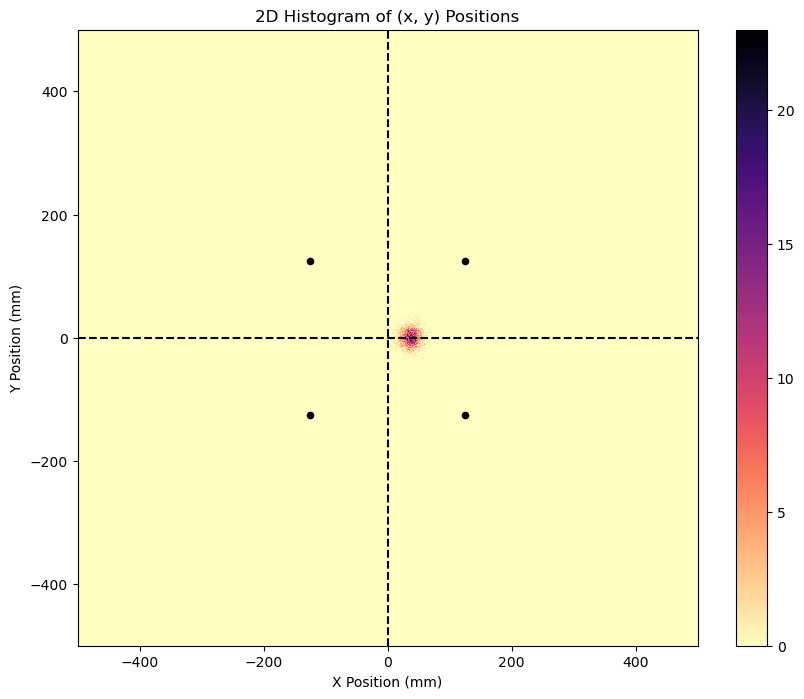

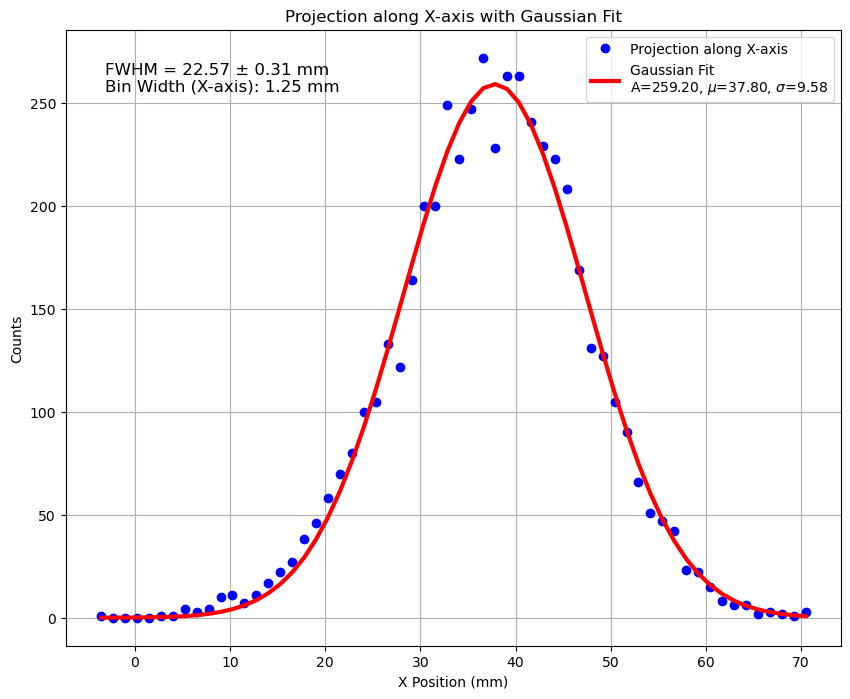

Chi-squared: 138.77
Degrees of freedom: 57
Critical value (df=57, alpha=0.05): 75.62
The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).


In [26]:
###More events
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_cells_fired(M, Nph):
    total_cells_fired = []
    for nph in Nph:
        total_cells_fired.append(round(M * (1 - math.exp(-nph / M))))
    return total_cells_fired

def calculate_total_charge_output(total_cells_fired, G, q):
    total_charge_output = [cells_fired * G * q for cells_fired in total_cells_fired]
    return total_charge_output

def read_Nph_from_file(filename):
    Nph_by_event = {}
    current_event = None
    event_counter = 0  # Counter to differentiate events with the same ID
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("Event ID"):
                event_id = float(line.split(":")[1].strip())
                if event_id in Nph_by_event:
                    event_id = f"{event_id}_{event_counter}"  # Append counter to make event IDs unique
                    event_counter += 1
                else:
                    event_counter = 0  # Reset counter when encountering a new event ID
                current_event = event_id
                Nph_by_event[current_event] = {0: 0, 1: 0, 2: 0, 3: 0}
            elif line.startswith("Detector ID"):
                parts = line.split(":")
                detector_id = int(float(parts[0].split()[-1]))
                Nph = float(parts[1].strip())
                if current_event in Nph_by_event:  
                    Nph_by_event[current_event][detector_id] = Nph
    return Nph_by_event

def calculate_position(Q_values, detector_positions):
    numerator_x = sum(Q_i**2 * pos[0] for Q_i, pos in zip(Q_values, detector_positions))
    numerator_y = sum(Q_i**2 * pos[1] for Q_i, pos in zip(Q_values, detector_positions))
    denominator = sum(Q_i**2 for Q_i in Q_values)

    x_position = numerator_x / denominator
    y_position = numerator_y / denominator

    return x_position, y_position

# Constants (MPPC S14160-6050HS)
M = 14331
G = 2.5e6  # G value
q = 1.6e-19  # charge of the electron value

# Detector positions
detector_positions = {
    0: (-12.5, 12.5),
    1: (-12.5, -12.5),
    2: (12.5, 12.5),
    3: (12.5, -12.5)
}

# Example usage:
filename = "/Users/rishaplamichhane/Downloads/MAPP_2_new copy/build_2/2.5 cm thickness/25 cm spacing/edge/1000_events_detector_id_counts_all_events.txt"  # Update with the filename generated from the previous code
Nph_by_event = read_Nph_from_file(filename)

# Calculate the total number of events
total_events = len(Nph_by_event)
print("Total number of events:", total_events)

x_values = []
y_values = []

for event_id, Nph_by_detector in Nph_by_event.items():
    total_fired = calculate_cells_fired(M, list(Nph_by_detector.values()))
    total_charge = calculate_total_charge_output(total_fired, G, q)
    detector_positions_sorted = [detector_positions[id] for id in sorted(Nph_by_detector.keys())]
    resulting_position = calculate_position(total_charge, detector_positions_sorted)
    x_values.append(resulting_position[0])
    y_values.append(resulting_position[1])
    
# Convert to NumPy arrays and multiply by 10 to convert from cm to mm
x_values_mm = np.array(x_values) * 10
y_values_mm = np.array(y_values) * 10

# Create a 2D histogram
plt.figure(figsize=(10, 8))
hist, x_edges, y_edges, _ =plt.hist2d(x_values_mm, y_values_mm, bins=60, cmap='magma_r')
cbar = plt.colorbar()
cbar.set_label('')  # Remove the label from the colorbar
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('2D Histogram of (x, y) Positions')
plt.grid(False)

plt.scatter([-125, -125, 125, 125], [125, -125, 125, -125], color='black', s=20)
    
# Add dashed lines for x and y axes
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.gca().set_facecolor('#FDFEC0')
plt.show()

# Create a 1D histogram projection along the X-axis
projection_x = np.sum(hist, axis=1)

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit Gaussian curve to the projection data
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
p0 = [max(projection_x), np.mean(x_bin_centers), (max(x_bin_centers) - min(x_bin_centers)) / 4]  # Updated initial guess
bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Bounds for parameters (lower, upper)
popt, pcov = curve_fit(gaussian, x_bin_centers, projection_x, p0=p0, bounds=bounds)

# Plot the projection along X-axis
plt.figure(figsize=(10, 8))
plt.plot(x_bin_centers, projection_x, 'bo', label='Projection along X-axis')
plt.xlabel('X Position (mm)')
plt.ylabel('Counts')
plt.title('Projection along X-axis with Gaussian Fit')
plt.grid(True)

# Calculate bin width along X-axis
bin_width_x = x_edges[1] - x_edges[0]

# Plot Gaussian fit
plt.plot(x_bin_centers, gaussian(x_bin_centers, *popt), 'r-', linewidth=3, label=f'Gaussian Fit\nA={popt[0]:.2f}, $\mu$={popt[1]:.2f}, $\sigma$={popt[2]:.2f}')  # Set linewidth=2 (or any other suitable value)

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # FWHM = 2 * sqrt(2 * ln(2)) * sigma

# Estimate uncertainty in FWHM
sigma_uncertainty = np.sqrt(np.diag(pcov))[2]  # Standard deviation of sigma parameter
fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty  # Uncertainty in FWHM

# Add legend and annotate FWHM
plt.legend()
plt.annotate(f'FWHM = {fwhm:.2f} ± {fwhm_uncertainty:.2f} mm\nBin Width (X-axis): {bin_width_x:.2f} mm', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

plt.show()

# Perform chi-squared test
# Compute the expected values from the Gaussian fit
expected_counts = gaussian(x_bin_centers, *popt)

# Calculate the degrees of freedom
# Number of bins - number of parameters fitted (A, mu, sigma)
degrees_of_freedom = len(projection_x) - 3

# Calculate the chi-squared statistic
chi_squared = np.sum((projection_x - expected_counts)**2 / expected_counts)

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Determine the critical chi-squared value for your chosen significance level (e.g., 0.05)
critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

print(f"Critical value (df={degrees_of_freedom}, alpha=0.05): {critical_value:.2f}")

# Compare chi-squared statistic with critical value
if chi_squared < critical_value:
    print("The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).")
else:
    print("The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).")


In [ ]:
##5cm spacing (0,0)

Total number of events: 5000


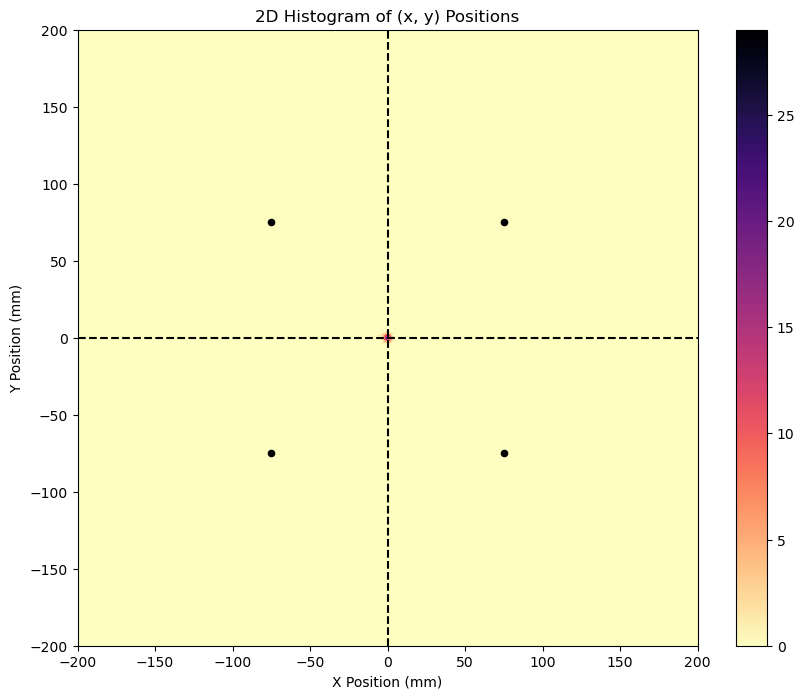

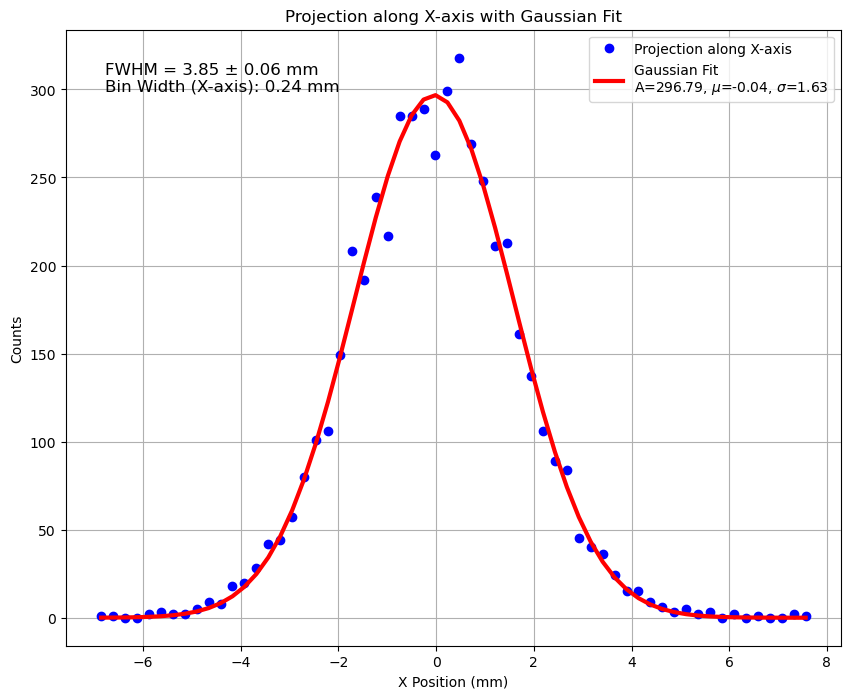

Chi-squared: 635.72
Degrees of freedom: 57
Critical value (df=57, alpha=0.05): 95.75
Skewness of the data: 0.99
The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).


In [53]:
###More events
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import skew

def calculate_cells_fired(M, Nph):
    total_cells_fired = []
    for nph in Nph:
        total_cells_fired.append(round(M * (1 - math.exp(-nph / M))))
    return total_cells_fired

def calculate_total_charge_output(total_cells_fired, G, q):
    total_charge_output = [cells_fired * G * q for cells_fired in total_cells_fired]
    return total_charge_output

def read_Nph_from_file(filename):
    Nph_by_event = {}
    current_event = None
    event_counter = 0  # Counter to differentiate events with the same ID
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("Event ID"):
                event_id = float(line.split(":")[1].strip())
                if event_id in Nph_by_event:
                    event_id = f"{event_id}_{event_counter}"  # Append counter to make event IDs unique
                    event_counter += 1
                else:
                    event_counter = 0  # Reset counter when encountering a new event ID
                current_event = event_id
                Nph_by_event[current_event] = {0: 0, 1: 0, 2: 0, 3: 0}
            elif line.startswith("Detector ID"):
                parts = line.split(":")
                detector_id = int(float(parts[0].split()[-1]))
                Nph = float(parts[1].strip())
                if current_event in Nph_by_event:  
                    Nph_by_event[current_event][detector_id] = Nph
    return Nph_by_event

def calculate_position(Q_values, detector_positions):
    numerator_x = sum(Q_i**2 * pos[0] for Q_i, pos in zip(Q_values, detector_positions))
    numerator_y = sum(Q_i**2 * pos[1] for Q_i, pos in zip(Q_values, detector_positions))
    denominator = sum(Q_i**2 for Q_i in Q_values)

    x_position = numerator_x / denominator
    y_position = numerator_y / denominator

    return x_position, y_position

# Constants (MPPC S14160-6050HS)
M = 14331
G = 2.5e6  # G value
q = 1.6e-19  # charge of the electron value

# Detector positions
detector_positions = {
    0: (-2.5, 2.5),
    1: (-2.5, -2.5),
    2: (2.5, 2.5),
    3: (2.5, -2.5)
}

# Example usage:
filename = "/Users/rishaplamichhane/Downloads/MAPP_2_new copy/build_2/2.5 cm thickness/5 cm spacing/center/5000_detector_id_counts_all_events.txt"  # Update with the filename generated from the previous code
Nph_by_event = read_Nph_from_file(filename)

# Calculate the total number of events
total_events = len(Nph_by_event)
print("Total number of events:", total_events)

x_values = []
y_values = []

for event_id, Nph_by_detector in Nph_by_event.items():
    total_fired = calculate_cells_fired(M, list(Nph_by_detector.values()))
    total_charge = calculate_total_charge_output(total_fired, G, q)
    detector_positions_sorted = [detector_positions[id] for id in sorted(Nph_by_detector.keys())]
    resulting_position = calculate_position(total_charge, detector_positions_sorted)
    x_values.append(resulting_position[0])
    y_values.append(resulting_position[1])
    
# Convert to NumPy arrays and multiply by 10 to convert from cm to mm
x_values_mm = np.array(x_values) * 10
y_values_mm = np.array(y_values) * 10

# Create a 2D histogram with more bins
plt.figure(figsize=(10, 8))
hist, x_edges, y_edges, _ = plt.hist2d(x_values_mm, y_values_mm, bins=60, cmap='magma_r')  # Increase the number of bins to 50
cbar = plt.colorbar()
cbar.set_label('')  # Remove the label from the colorbar
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('2D Histogram of (x, y) Positions')
plt.grid(False)

plt.scatter([-75, -75, 75, 75], [75, -75, 75, -75], color='black', s=20)

# Add dashed lines for x and y axes
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.gca().set_facecolor('#FDFEC0')
plt.show()

# Create a 1D histogram projection along the X-axis
projection_x = np.sum(hist, axis=1)

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit Gaussian curve to the projection data
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
restricted_range = (x_bin_centers >= -6) & (x_bin_centers <= 6)
x_bin_centers_restricted = x_bin_centers[restricted_range]
projection_x_restricted = projection_x[restricted_range]
p0 = [max(projection_x_restricted), np.mean(x_bin_centers_restricted), (max(x_bin_centers_restricted) - min(x_bin_centers_restricted)) / 4]  # Updated initial guess
bounds = ([0, -6, 0], [np.inf, 6, np.inf])  # Bounds for parameters (lower, upper)
popt, pcov = curve_fit(gaussian, x_bin_centers_restricted, projection_x_restricted, p0=p0, bounds=bounds)

# Plot the projection along X-axis
plt.figure(figsize=(10, 8))
plt.plot(x_bin_centers, projection_x, 'bo', label='Projection along X-axis')
plt.xlabel('X Position (mm)')
plt.ylabel('Counts')
plt.title('Projection along X-axis with Gaussian Fit')
plt.grid(True)

# Calculate bin width along X-axis
bin_width_x = x_edges[1] - x_edges[0]

# Plot Gaussian fit
plt.plot(x_bin_centers, gaussian(x_bin_centers, *popt), 'r-', linewidth=3, label=f'Gaussian Fit\nA={popt[0]:.2f}, $\mu$={popt[1]:.2f}, $\sigma$={popt[2]:.2f}')  # Set linewidth=2 (or any other suitable value)

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # FWHM = 2 * sqrt(2 * ln(2)) * sigma

# Estimate uncertainty in FWHM
sigma_uncertainty = np.sqrt(np.diag(pcov))[2]  # Standard deviation of sigma parameter
fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty  # Uncertainty in FWHM

# Add legend and annotate FWHM
plt.legend()
plt.annotate(f'FWHM = {fwhm:.2f} ± {fwhm_uncertainty:.2f} mm\nBin Width (X-axis): {bin_width_x:.2f} mm', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

plt.show()

# Perform chi-squared test
# Compute the expected values from the Gaussian fit
expected_counts = gaussian(x_bin_centers, *popt)

# Calculate the degrees of freedom
# Number of bins - number of parameters fitted (A, mu, sigma)
degrees_of_freedom = len(projection_x) - 3

# Calculate the chi-squared statistic
chi_squared = np.sum((projection_x - expected_counts)**2 / expected_counts)

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Determine the critical chi-squared value for your chosen significance level (e.g., 0.05)
critical_value = chi2.ppf(1 - 0.001, degrees_of_freedom)

print(f"Critical value (df={degrees_of_freedom}, alpha=0.05): {critical_value:.2f}")

# Compute skewness of the data
skewness = skew(projection_x)
print(f"Skewness of the data: {skewness:.2f}")

# Compare chi-squared statistic with critical value
if chi_squared < critical_value:
    print("The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).")
else:
    print("The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).")


Total number of events: 5000


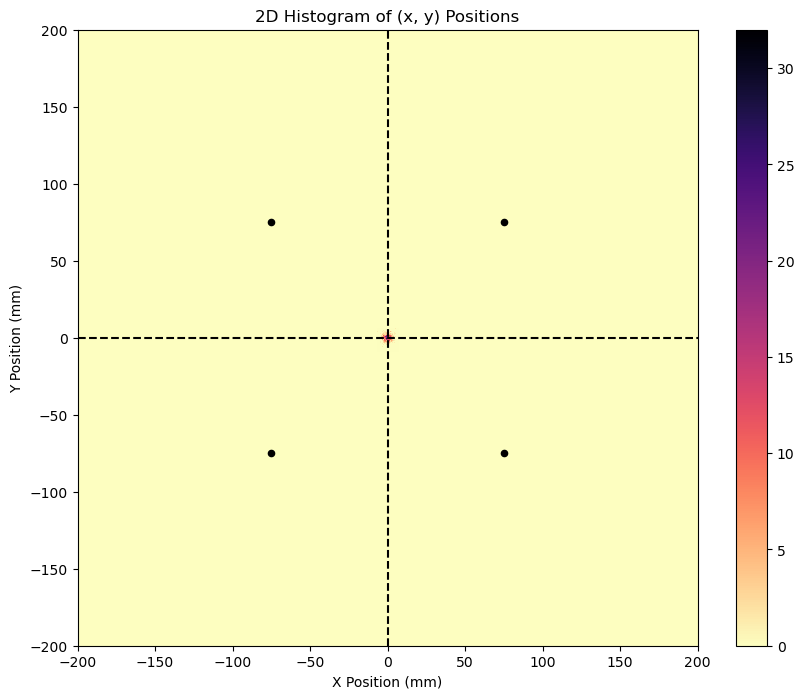

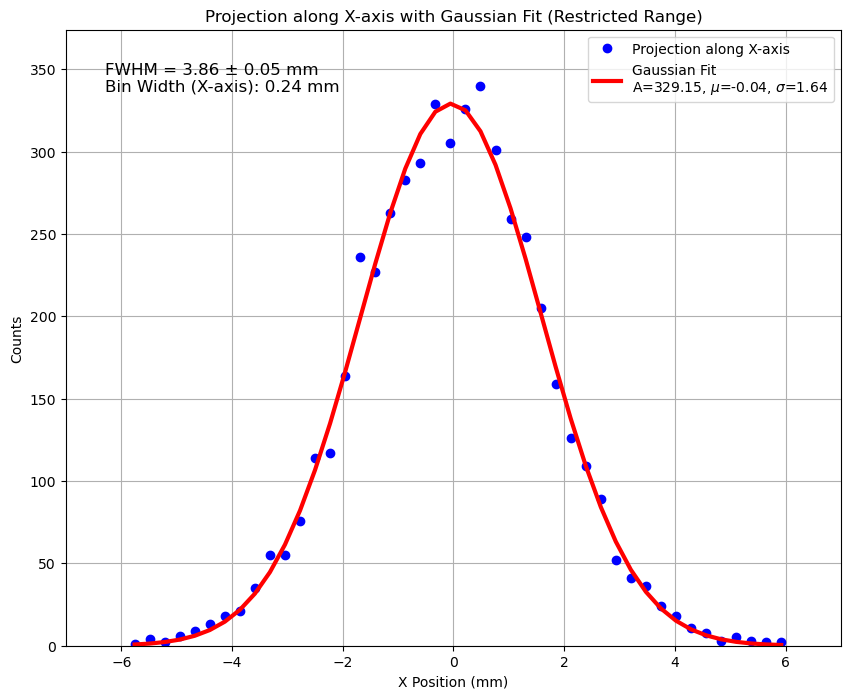

Chi-squared: 49.62
Degrees of freedom: 41
Critical value (df=41, alpha=0.05): 56.94
The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).


In [68]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

def calculate_cells_fired(M, Nph):
    total_cells_fired = []
    for nph in Nph:
        total_cells_fired.append(round(M * (1 - math.exp(-nph / M))))
    return total_cells_fired

def calculate_total_charge_output(total_cells_fired, G, q):
    total_charge_output = [cells_fired * G * q for cells_fired in total_cells_fired]
    return total_charge_output

def read_Nph_from_file(filename):
    Nph_by_event = {}
    current_event = None
    event_counter = 0  # Counter to differentiate events with the same ID
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("Event ID"):
                event_id = float(line.split(":")[1].strip())
                if event_id in Nph_by_event:
                    event_id = f"{event_id}_{event_counter}"  # Append counter to make event IDs unique
                    event_counter += 1
                else:
                    event_counter = 0  # Reset counter when encountering a new event ID
                current_event = event_id
                Nph_by_event[current_event] = {0: 0, 1: 0, 2: 0, 3: 0}
            elif line.startswith("Detector ID"):
                parts = line.split(":")
                detector_id = int(float(parts[0].split()[-1]))
                Nph = float(parts[1].strip())
                if current_event in Nph_by_event:  
                    Nph_by_event[current_event][detector_id] = Nph
    return Nph_by_event

def calculate_position(Q_values, detector_positions):
    numerator_x = sum(Q_i**2 * pos[0] for Q_i, pos in zip(Q_values, detector_positions))
    numerator_y = sum(Q_i**2 * pos[1] for Q_i, pos in zip(Q_values, detector_positions))
    denominator = sum(Q_i**2 for Q_i in Q_values)

    x_position = numerator_x / denominator
    y_position = numerator_y / denominator

    return x_position, y_position

# Constants (MPPC S14160-6050HS)
M = 14331
G = 2.5e6  # G value
q = 1.6e-19  # charge of the electron value

# Detector positions
detector_positions = {
    0: (-2.5, 2.5),
    1: (-2.5, -2.5),
    2: (2.5, 2.5),
    3: (2.5, -2.5)
}

# Example usage:
filename = "/Users/rishaplamichhane/Downloads/MAPP_2_new copy/build_2/2.5 cm thickness/5 cm spacing/center/5000_detector_id_counts_all_events.txt"  # Update with the filename generated from the previous code
Nph_by_event = read_Nph_from_file(filename)

# Calculate the total number of events
total_events = len(Nph_by_event)
print("Total number of events:", total_events)

x_values = []
y_values = []

for event_id, Nph_by_detector in Nph_by_event.items():
    total_fired = calculate_cells_fired(M, list(Nph_by_detector.values()))
    total_charge = calculate_total_charge_output(total_fired, G, q)
    detector_positions_sorted = [detector_positions[id] for id in sorted(Nph_by_detector.keys())]
    resulting_position = calculate_position(total_charge, detector_positions_sorted)
    x_values.append(resulting_position[0])
    y_values.append(resulting_position[1])
    
# Convert to NumPy arrays and multiply by 10 to convert from cm to mm
x_values_mm = np.array(x_values) * 10
y_values_mm = np.array(y_values) * 10

# Create a 2D histogram with more bins
plt.figure(figsize=(10, 8))
hist, x_edges, y_edges, _ = plt.hist2d(x_values_mm, y_values_mm, bins=54, cmap='magma_r')  # Increase the number of bins to 50
cbar = plt.colorbar()
cbar.set_label('')  # Remove the label from the colorbar
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('2D Histogram of (x, y) Positions')
plt.grid(False)

plt.scatter([-75, -75, 75, 75], [75, -75, 75, -75], color='black', s=20)

# Add dashed lines for x and y axes
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.gca().set_facecolor('#FDFEC0')
plt.show()

# Create a 1D histogram projection along the X-axis
projection_x = np.sum(hist, axis=1)

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit Gaussian curve to the projection data with restricted range and bounds
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
restricted_range = (x_bin_centers >= -6) & (x_bin_centers <= 6)
x_bin_centers_restricted = x_bin_centers[restricted_range]
projection_x_restricted = projection_x[restricted_range]
p0 = [max(projection_x_restricted), np.mean(x_bin_centers_restricted), (max(x_bin_centers_restricted) - min(x_bin_centers_restricted)) / 4]  # Updated initial guess
bounds = ([0, -6, 0], [np.inf, 6, np.inf])  # Bounds for parameters (lower, upper)
popt, pcov = curve_fit(gaussian, x_bin_centers_restricted, projection_x_restricted, p0=p0, bounds=bounds)

# Plot the projection along X-axis with restricted range
plt.figure(figsize=(10, 8))
plt.plot(x_bin_centers_restricted, projection_x_restricted, 'bo', label='Projection along X-axis')
plt.xlabel('X Position (mm)')
plt.ylabel('Counts')
plt.title('Projection along X-axis with Gaussian Fit (Restricted Range)')
plt.grid(True)

# Plot Gaussian fit
plt.plot(x_bin_centers_restricted, gaussian(x_bin_centers_restricted, *popt), 'r-', linewidth=3, label=f'Gaussian Fit\nA={popt[0]:.2f}, $\mu$={popt[1]:.2f}, $\sigma$={popt[2]:.2f}')  # Set linewidth=2 (or any other suitable value)

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # FWHM = 2 * sqrt(2 * ln(2)) * sigma

# Estimate uncertainty in FWHM
sigma_uncertainty = np.sqrt(np.diag(pcov))[2]  # Standard deviation of sigma parameter
fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty  # Uncertainty in FWHM

# Add legend and annotate FWHM
plt.legend()
plt.annotate(f'FWHM = {fwhm:.2f} ± {fwhm_uncertainty:.2f} mm\nBin Width (X-axis): {bin_width_x:.2f} mm', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

plt.xlim(-7, 7)  # Adjust x-axis limits to show restricted range
plt.ylim(0, max(projection_x) * 1.1)  # Adjust y-axis limits for better visualization
plt.show()

# Perform chi-squared test
# Compute the expected values from the Gaussian fit
expected_counts = gaussian(x_bin_centers_restricted, *popt)

# Calculate the degrees of freedom
# Number of bins - number of parameters fitted (A, mu, sigma)
degrees_of_freedom = len(projection_x_restricted) - 3

# Calculate the chi-squared statistic
chi_squared = np.sum((projection_x_restricted - expected_counts)**2 / expected_counts)

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Determine the critical chi-squared value for your chosen significance level (e.g., 0.05)
critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

print(f"Critical value (df={degrees_of_freedom}, alpha=0.05): {critical_value:.2f}")

# Compare chi-squared statistic with critical value
if chi_squared < critical_value:
    print("The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).")
else:
    print("The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).")


In [173]:
##5cm spacing (2,0)

Total number of events: 5000


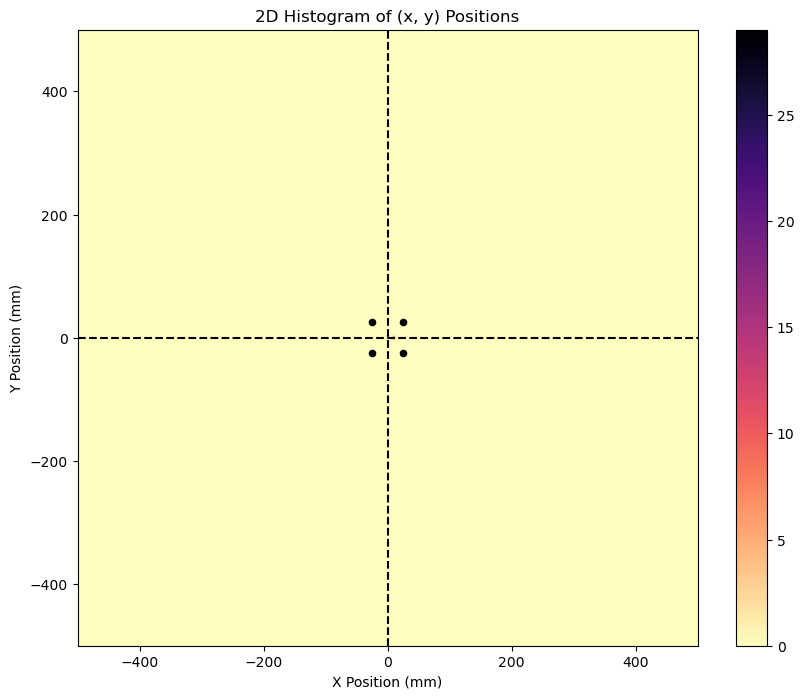

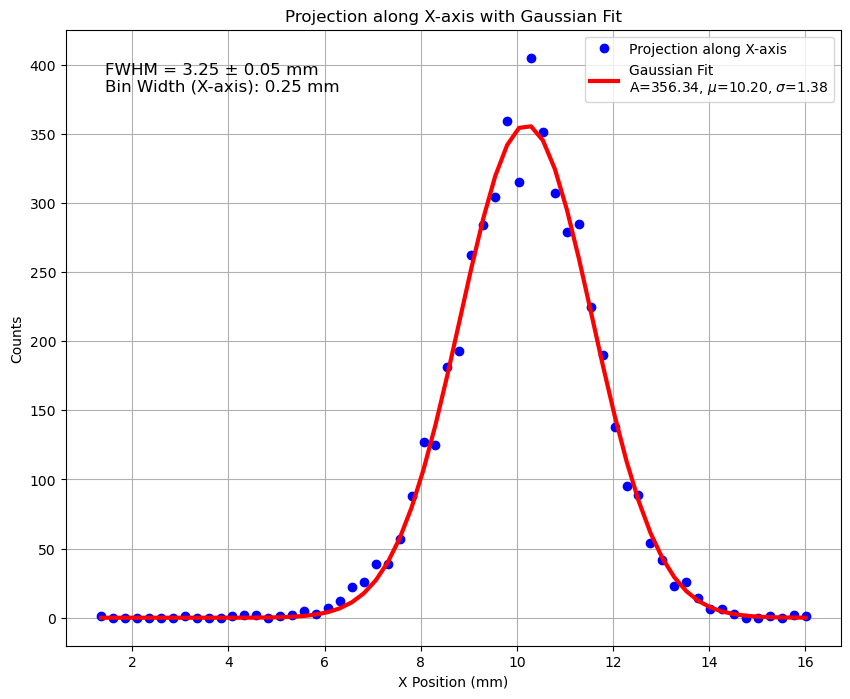

Chi-squared: 2462378.24
Degrees of freedom: 57
Critical value (df=57, alpha=0.05): 75.62
The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).


In [28]:
###More events
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_cells_fired(M, Nph):
    total_cells_fired = []
    for nph in Nph:
        total_cells_fired.append(round(M * (1 - math.exp(-nph / M))))
    return total_cells_fired

def calculate_total_charge_output(total_cells_fired, G, q):
    total_charge_output = [cells_fired * G * q for cells_fired in total_cells_fired]
    return total_charge_output

def read_Nph_from_file(filename):
    Nph_by_event = {}
    current_event = None
    event_counter = 0  # Counter to differentiate events with the same ID
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("Event ID"):
                event_id = float(line.split(":")[1].strip())
                if event_id in Nph_by_event:
                    event_id = f"{event_id}_{event_counter}"  # Append counter to make event IDs unique
                    event_counter += 1
                else:
                    event_counter = 0  # Reset counter when encountering a new event ID
                current_event = event_id
                Nph_by_event[current_event] = {0: 0, 1: 0, 2: 0, 3: 0}
            elif line.startswith("Detector ID"):
                parts = line.split(":")
                detector_id = int(float(parts[0].split()[-1]))
                Nph = float(parts[1].strip())
                if current_event in Nph_by_event:  
                    Nph_by_event[current_event][detector_id] = Nph
    return Nph_by_event

def calculate_position(Q_values, detector_positions):
    numerator_x = sum(Q_i**2 * pos[0] for Q_i, pos in zip(Q_values, detector_positions))
    numerator_y = sum(Q_i**2 * pos[1] for Q_i, pos in zip(Q_values, detector_positions))
    denominator = sum(Q_i**2 for Q_i in Q_values)

    x_position = numerator_x / denominator
    y_position = numerator_y / denominator

    return x_position, y_position

# Constants (MPPC S14160-6050HS)
M = 14331
G = 2.5e6  # G value
q = 1.6e-19  # charge of the electron value

# Detector positions
detector_positions = {
    0: (-2.5, 2.5),
    1: (-2.5, -2.5),
    2: (2.5, 2.5),
    3: (2.5, -2.5)
}

# Example usage:
filename = "/Users/rishaplamichhane/Downloads/MAPP_2_new copy/build_2/2.5 cm thickness/5 cm spacing/edge/5000_detector_id_counts_all_events.txt"  # Update with the filename generated from the previous code
Nph_by_event = read_Nph_from_file(filename)

# Calculate the total number of events
total_events = len(Nph_by_event)
print("Total number of events:", total_events)

x_values = []
y_values = []

for event_id, Nph_by_detector in Nph_by_event.items():
    total_fired = calculate_cells_fired(M, list(Nph_by_detector.values()))
    total_charge = calculate_total_charge_output(total_fired, G, q)
    detector_positions_sorted = [detector_positions[id] for id in sorted(Nph_by_detector.keys())]
    resulting_position = calculate_position(total_charge, detector_positions_sorted)
    x_values.append(resulting_position[0])
    y_values.append(resulting_position[1])
    
# Convert to NumPy arrays and multiply by 10 to convert from cm to mm
x_values_mm = np.array(x_values) * 10
y_values_mm = np.array(y_values) * 10

# Create a 2D histogram
plt.figure(figsize=(10, 8))
hist, x_edges, y_edges, _ =plt.hist2d(x_values_mm, y_values_mm, bins=60, cmap='magma_r')
cbar = plt.colorbar()
cbar.set_label('')  # Remove the label from the colorbar
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('2D Histogram of (x, y) Positions')
plt.grid(False)

plt.scatter([-25, -25, 25, 25], [25, -25, 25, -25], color='black', s=20)
    
# Add dashed lines for x and y axes
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.gca().set_facecolor('#FDFEC0')
plt.show()

# Create a 1D histogram projection along the X-axis
projection_x = np.sum(hist, axis=1)

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit Gaussian curve to the projection data
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
# Initial guess for parameters
p0 = [max(projection_x), np.mean(x_bin_centers), (max(x_bin_centers) - min(x_bin_centers)) / 4]  

# Bounds for parameters (lower, upper)
bounds = ([0, min(x_bin_centers), 0], [np.inf, max(x_bin_centers), np.inf])  
popt, pcov = curve_fit(gaussian, x_bin_centers, projection_x, p0=p0, bounds=bounds)

# Plot the projection along X-axis
plt.figure(figsize=(10, 8))
plt.plot(x_bin_centers, projection_x, 'bo', label='Projection along X-axis')
plt.xlabel('X Position (mm)')
plt.ylabel('Counts')
plt.title('Projection along X-axis with Gaussian Fit')
plt.grid(True)

# Calculate bin width along X-axis
bin_width_x = x_edges[1] - x_edges[0]

# Plot Gaussian fit
plt.plot(x_bin_centers, gaussian(x_bin_centers, *popt), 'r-', linewidth=3, label=f'Gaussian Fit\nA={popt[0]:.2f}, $\mu$={popt[1]:.2f}, $\sigma$={popt[2]:.2f}')  # Set linewidth=2 (or any other suitable value)

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # FWHM = 2 * sqrt(2 * ln(2)) * sigma

# Estimate uncertainty in FWHM
sigma_uncertainty = np.sqrt(np.diag(pcov))[2]  # Standard deviation of sigma parameter
fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty  # Uncertainty in FWHM

# Add legend and annotate FWHM
plt.legend()
plt.annotate(f'FWHM = {fwhm:.2f} ± {fwhm_uncertainty:.2f} mm\nBin Width (X-axis): {bin_width_x:.2f} mm', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

plt.show()

# Perform chi-squared test
# Compute the expected values from the Gaussian fit
expected_counts = gaussian(x_bin_centers, *popt)

# Calculate the degrees of freedom
# Number of bins - number of parameters fitted (A, mu, sigma)
degrees_of_freedom = len(projection_x) - 3

# Calculate the chi-squared statistic
chi_squared = np.sum((projection_x - expected_counts)**2 / expected_counts)

print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Determine the critical chi-squared value for your chosen significance level (e.g., 0.05)
critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

print(f"Critical value (df={degrees_of_freedom}, alpha=0.05): {critical_value:.2f}")

# Compare chi-squared statistic with critical value
if chi_squared < critical_value:
    print("The Gaussian fit is a reasonable representation of the data (null hypothesis accepted).")
else:
    print("The Gaussian fit is not a reasonable representation of the data (null hypothesis rejected).")
